# Packages

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import random

from collections import Counter

# Models

## DCA

In [206]:
a = 0.8
b = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0]

closest_number = max(b, key=lambda x: abs(x - a))

print(closest_number)

0.1


In [207]:
a = [0.1, 0.2, 0.3, 0.4, 0.5]

def calculate_normalised_global_fairness(accumulated_rewards, alloc, credit):
    r1, r2 = accumulated_rewards[0], accumulated_rewards[1]
    alloc1, alloc2 = alloc, 1-alloc
    gf = lambda x : pow((r1+credit*x)*(r2+credit*(1-x)), 1/2)

    current_f = pow((r1+credit*alloc1)*(r2+credit*alloc2), 1/2)
    min_f = 0
    max_f = 1
    if abs(r1-r2)<=credit:
      opt_a = (credit + r2 - r1) / (2*credit)
      # max_f = 0.5*(r1+r2+credit)

      best = min(a, key=lambda x: abs(x - opt_a))
      worst = max(a, key=lambda x: abs(x - opt_a))
    else:
      if r1>r2:
        best = min(a)
        worst = max(a)
      else:
        best = max(a)
        worst = min(a)

    min_f = gf(worst)
    max_f = gf(best)

    if min_f==max_f:
      return 0

    return (current_f - min_f)/(max_f - min_f)

In [208]:
num = calculate_normalised_global_fairness([110, 100], 0.1, 20)
print(num)

0.6667675697654847


Designer

In [209]:
class Designer():
  def __init__(self, single_alloc, avail_alloc, n, designer_type = "local_fair"):
    self.single_cell_alloc = np.array(single_alloc)
    self.avail_alloc = avail_alloc
    self.n = n
    # self.game_rewards = game_rewards
    self.designer_type = designer_type

    self.policy = [1/len(avail_alloc)] * len(avail_alloc)
    self.fairness_function = lambda v: pow(np.prod(v), 1/len(v)) # NSW
    self.exploration = 1

    self.local_fairness_trace = []
    self.r_local_fairness_trace = []
    self.global_fairness_trace = []
    self.policy_trace = [1/len(avail_alloc)]
    self.choice_trace = []

  def _calculate_normalised_local_fairness(self, alloc, credit, max_credit, lf_type = 'simple'):
    a, b = alloc, 1-alloc

    worst1 = min(min(self.single_cell_alloc), min(1-self.single_cell_alloc))
    worst2 = 1-worst1

    best_idx = np.argmin(abs(np.array(self.single_cell_alloc-0.5)))
    best1, best2 = self.single_cell_alloc[best_idx], 1-self.single_cell_alloc[best_idx]

    if lf_type == 'simple':
      return (pow(a*b, 1/2) - pow(worst1*worst2, 1/2))/(pow(best1*best2, 1/2) - pow(worst1*worst2, 1/2))
    elif lf_type == 'reward-related':
      return credit * pow(a*b, 1/2)/pow(best1*best2, 1/2)
    else:
      print('Undefined LF type')
      return

  def _calculate_normalised_global_fairness(self, accumulated_rewards, alloc, credit):
    a = self.single_cell_alloc
    r1, r2 = accumulated_rewards[0], accumulated_rewards[1]
    alloc1, alloc2 = alloc, 1-alloc
    gf = lambda x : pow((r1+credit*x)*(r2+credit*(1-x)), 1/2)

    current_f = pow((r1+credit*alloc1)*(r2+credit*alloc2), 1/2)
    min_f = 0
    max_f = 1
    if abs(r1-r2)<=credit:
      opt_a = (credit + r2 - r1) / (2*credit)
      # max_f = 0.5*(r1+r2+credit)

      best = min(a, key=lambda x: abs(x - opt_a))
      worst = max(a, key=lambda x: abs(x - opt_a))
    else:
      if r1>r2:
        best = min(a)
        worst = max(a)
      else:
        best = max(a)
        worst = min(a)

    min_f = gf(worst)
    max_f = gf(best)

    if min_f==max_f:
      return 0

    return (current_f - min_f)/(max_f - min_f)

  def _calculate_gf_for_plot(self, accumulated_rewards, alloc, credit):
    r1, r2 = accumulated_rewards[0], accumulated_rewards[1]
    alloc1, alloc2 = alloc, 1-alloc
    current_f = pow((r1+credit*alloc1)*(r2+credit*alloc2), 1/2)
    min_f = 0
    max_f = 1
    if abs(r1-r2)<=credit:
      max_f = 0.5*(r1+r2+credit)
      if r1>r2:
        min_f = pow((r1+credit)*r2, 1/2)
      else:
        min_f = pow((r2+credit)*r1, 1/2)
    else:
      if r1>r2:
        min_f = pow((r1+credit)*r2, 1/2)
        max_f = pow((r2+credit)*r1, 1/2)
      else:
        min_f = pow((r2+credit)*r1, 1/2)
        max_f = pow((r1+credit)*r2, 1/2)

    if min_f==max_f:
      return 0

    return (current_f - min_f)/(max_f - min_f)

  def update_policy(self, action, accumulated_rewards, credit, max_credit, normalized_credit, current_alloc_idx, current_step):
    self.choice_trace.append(current_alloc_idx)

    current_alloc1 = self.avail_alloc[current_alloc_idx][action[0]][action[1]]
    current_alloc2 = 1- current_alloc1

    # normalised local fairness for all allocations (range from 0 to 1) - for comparison
    normalized_local_fairness = 2*pow(current_alloc1*current_alloc2, 1/self.n)
    r_related_normalised_local_fairness = 2*credit*pow(current_alloc1*current_alloc2, 1/self.n)/max_credit

    self.local_fairness_trace.append(normalized_local_fairness)
    self.r_local_fairness_trace.append(r_related_normalised_local_fairness)

    # normalised local fairness for current allocation space - for updating policy
    normalized_local_fairness = self._calculate_normalised_local_fairness(current_alloc1, normalized_credit, max_credit)
    r_related_normalised_local_fairness = self._calculate_normalised_local_fairness(current_alloc1, normalized_credit, max_credit, 'reward-related')

    global_normalised_fairness = self._calculate_normalised_global_fairness(accumulated_rewards, current_alloc1, credit)
    self.exploration = 1-global_normalised_fairness
    # self.exploration = 1- pow(global_normalised_fairness, 7)

    self.global_fairness_trace.append(self._calculate_gf_for_plot(accumulated_rewards, current_alloc1, credit))

    # Designer varies, reward varies
    reward = 0
    if self.designer_type == "local_fair":
      reward = pow(normalized_local_fairness, 7)

    elif self.designer_type == "reward_related_local_fair":
      reward = pow(r_related_normalised_local_fairness, 7)

    elif self.designer_type == "global_fair":
      reward = global_normalised_fairness
      # reward = pow(global_normalised_fairness, 7)

    elif self.designer_type == "optimal":
      reward = pow(normalized_credit, 7)
      # reward = self._calculate_optimal_reward(normalized_credit)

    elif self.designer_type == "random":
      return
    elif self.designer_type == "still":
      reward = 1
    else:
      print("Designer",self.designer_type, "does not exist.")
      return

    # update policy
    for i in range(len(self.avail_alloc)):
      if i == current_alloc_idx:
        self.policy[i] += reward - self.policy[i]*reward
      else:
        self.policy[i] += -self.policy[i]*reward

    self.policy_trace.append(max(self.policy))

  def take_action(self):
    explore = random.uniform(0, 1)
    p = self.policy

    if self.designer_type == "global_fair" and explore < self.exploration:
      p = [1/len(self.avail_alloc)] * len(self.avail_alloc)

    index, selected = random.choices(list(enumerate(self.avail_alloc)), p)[0]
    return selected, index

Player

In [210]:
class Agent():
  def __init__(self, actions):
    self.actions = actions
    self.policy = [1/len(actions)]*len(actions)
    self.reward = 0
    self.policy_trace = {action: [1/len(actions)] for action in self.actions}
    self.policy_max_trace = [max(self.policy)]

    self.reward_trace = [0]
    self.single_reward_trace = []
    self.policy_choice_trace = []

  def take_action(self):
    a = np.random.choice(self.actions, p=self.policy)
    self.policy_choice_trace.append(a)
    return a

  def update_policy(self, reward, current_action):
    for i in range(len(self.actions)):
      change = 0
      if self.actions[i] == current_action:
        self.policy[i] += reward - self.policy[i]* reward
      else:
        self.policy[i] -= self.policy[i]*reward

      self.policy_trace[i].append(self.policy[i])

    self.policy_max_trace.append(self.policy)

  def update_reward(self, reward):
    self.single_reward_trace.append(reward)
    self.reward+=reward
    self.reward_trace.append(self.reward)


Game

In [211]:
class Game():
  def __init__(self, rewards):
    self.rewards = rewards

  def get_max_reward(self):
    return np.amax(self.rewards)

  def get_reward(self, actions, game_type="original"):
    reward = self.rewards
    if game_type == "normalized":
      reward = (self.rewards-np.amin(self.rewards))/(np.amax(self.rewards)-np.amin(self.rewards))

    for action in actions:
      reward = reward[action]
    return reward

  def play(self, allocation, actions, game_type="original"):
    selected_reward = self.get_reward(actions, game_type)
    allocated_rewards = [selected_reward*allocation[actions[0]][actions[1]], selected_reward*(1-allocation[actions[0]][actions[1]])]

    return allocated_rewards


Run

In [212]:
OPTIMAL_INTERNEL_SIZE = 7

class Cross_Learning_Playground():
  def __init__(self, designer, agents, game, iter_num):
    self.designer = designer
    self.agents = agents
    self.game = game
    self.iter_num = iter_num
    self.fisrt_actions = None

    self.normalised_reward_trace = []

  def train(self):
    # accumulated_reward = 0
    current_alloc, current_alloc_idx = None, None
    game_max_reward = self.game.get_max_reward()
    for iter in range(self.iter_num):
      if self.designer.designer_type == 'optimal':
        if iter % OPTIMAL_INTERNEL_SIZE == 0:
          current_alloc, current_alloc_idx = self.designer.take_action()
      else:
        current_alloc, current_alloc_idx = self.designer.take_action()
      current_actions = [agent.take_action() for agent in self.agents]
      if iter == 0:
        self.first_actions = current_actions
      rewards = self.game.play(current_alloc, current_actions)
      normalized_rewards = self.game.play(current_alloc, current_actions, "normalized")
      self.normalised_reward_trace.append(normalized_rewards)
      # accumulated_reward += sum(normalized_rewards)

      agent_accumulated_rewards = [agent.reward for agent in self.agents]
      for i in range(len(self.agents)):
        self.agents[i].update_policy(normalized_rewards[i], current_actions[i])
        self.agents[i].update_reward(rewards[i])
        # print(self.agents[i].reward)

      if self.designer.designer_type == 'optimal':
        if iter % OPTIMAL_INTERNEL_SIZE == 0 and iter!=0:
          # accumulated_reward /= OPTIMAL_INTERNEL_SIZE
          self.designer.update_policy(current_actions, agent_accumulated_rewards, sum(rewards), game_max_reward, sum(normalized_rewards), current_alloc_idx, iter+1)
          # accumulated_reward = 0
      else:
        self.designer.update_policy(current_actions, agent_accumulated_rewards, sum(rewards), game_max_reward, sum(normalized_rewards), current_alloc_idx, iter+1)

## Benchmark - JAL

In [131]:
class Agent_Group():
  def __init__(self, actions):
    self.actions = actions
    self.policy = [1/len(actions)]*len(actions)
    self.reward = 0
    self.reward_trace = [self.reward]

    self.policy_trace = {i: [1/len(actions)] for i in range(len(actions))}
    # self.change_trace = {i: [] for i in range(len(actions))}

  def take_action(self):
    return random.choices(full_actions, weights=self.policy, k=1)[0]

  def update_policy(self, reward, current_action):
    for i in range(len(self.actions)):
      change = 0
      if self.actions[i] == current_action:
        self.policy[i] += reward - self.policy[i]* reward
      else:
        self.policy[i] -= self.policy[i]*reward

      self.policy_trace[i].append(self.policy[i])

  def update_reward(self, reward):
    self.reward+=reward

In [132]:
class JA_Game():
  def __init__(self, rewards):
    self.rewards = rewards

  def play(self, actions, game_type="original"):
    reward = self.rewards
    if game_type == "normalized":
      reward = (self.rewards-np.amin(self.rewards))/(np.amax(self.rewards)-np.amin(self.rewards))

    for action in actions:
      reward = reward[action]
    return reward/2


In [133]:
class Joint_Action_Learning_Playground():
  def __init__(self, agent_group, game, iter_num):
    self.agent_group = agent_group
    self.game = game
    self.iter_num = iter_num

  def train(self):
    for i in range(self.iter_num):
      current_actions = self.agent_group.take_action()
      reward = self.game.play(current_actions)
      normalized_reward = self.game.play(current_actions, "normalized")

      self.agent_group.update_policy(normalized_reward, current_actions)
      self.agent_group.update_reward(reward)


## Target - IL (with optimal allocation)

In [134]:
class IL_Game():
  def __init__(self, rewards):
    self.rewards = rewards

  def play(self, actions, game_type="original"):
    reward = self.rewards
    if game_type == "normalized":
      reward = (self.rewards-np.amin(self.rewards))/(np.amax(self.rewards)-np.amin(self.rewards))

    for action in actions:
      reward = reward[action]
    return reward

In [135]:
class Independent_Learning_Playground():
  def __init__(self, agents, game, iter_num):
    self.agents = agents
    self.game = game
    self.iter_num = iter_num
    self.normalised_reward_trace = []

  def train(self):
    for iter in range(self.iter_num):
      current_actions = [agent.take_action() for agent in self.agents]
      rewards = self.game.play(current_actions)
      # normalized_rewards = self.game.play(current_actions, "normalized")
      normalized_rewards = rewards
      self.normalised_reward_trace.append(normalized_rewards)

      agent_rewards = [agent.reward for agent in self.agents]
      for i in range(len(self.agents)):
        self.agents[i].update_policy(normalized_rewards[i], current_actions[i])
        self.agents[i].update_reward(rewards[i])

# Training Settings

## DCA

Reward tables

In [213]:
# Single NE - exist optimal allocations
game_rewards1 = np.array([[20, 10],
                          [8, 14]])

# game_rewards1 = np.array([[20, 10, 5],
#                           [10, 15, 8],
#                           [5, 12, 15]])

# Multi NE - no optimal allocations
game_rewards2 = np.array([[4, 0],
                          [0, 2]])

# Prisoner Dilemma
game_rewards3 = np.array([[40, 25],
                          [25, 20]])

# game_rewards3 = np.array([[20, 10],
#                           [14, 8]])

Action Space

In [214]:
# Designer allocation space
op_single_alloc = [ 1/4, 3/8, 1/2, 5/8, 3/4]
# op_single_alloc = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
op_full_alloc = [[[a,b],[c,d]] for a in op_single_alloc for b in op_single_alloc for c in op_single_alloc for d in op_single_alloc]

single_alloc = {"optimal": op_single_alloc, "local_fair": op_single_alloc, "global_fair": op_single_alloc,"reward_related_local_fair":op_single_alloc, "random":op_single_alloc, "still":op_single_alloc}
full_alloc = {"optimal": op_full_alloc, "local_fair": op_full_alloc, "global_fair": op_full_alloc, "reward_related_local_fair":op_full_alloc, "random":op_full_alloc, "still":op_full_alloc}

# Player action space
agent1_action = [0,1]
agent2_action = [0,1]

## JAL

In [138]:
# Single NE - exist optimal allocations
JAL_game_rewards1 = np.array([[20, 10],
                              [8, 14]])

# Multi NE - no optimal allocations
JAL_game_rewards2 = np.array([[20, 10],
                              [5, 15]])

# Prisoner Dilemma
JAL_game_rewards3 = np.array([[40, 25],
                              [25, 20]])

JAL_game_rewards3 = np.array([[20, 10],
                              [14, 8]])

In [139]:
agent1_action = [0,1]
agent2_action = [0,1]

full_actions = [[a,b] for a in agent1_action for b in agent2_action]

## IL

In [140]:
# Single NE
IL_MNE_game_SNE = np.array([[[0.5,0.5], [2/15,1/30]],
                             [[0,0], [1/4,1/4]]])

IL_MNE_game_MNE = np.array([[[0.5,0.5], [1/12,1/12]],
                             [[0,0], [1/4,1/4]]])

# IL_MNE_game_MNE = np.array([[[0.5,0.5], [0.0475,143/1200]],
#                              [[0,0], [0.1425,0.3575]]])

IL_MNE_game_NNE = np.array([[[0.5,0.5], [1/30,2/15]],
                             [[0,0], [1/7,5/14]]])

IL_game_rewards1 = np.array([[[0.5,0.5], [1/12,1/12]],
                             [[1/4,1/4], [0,0]]])

IL_game_rewards1 = np.array([[[0.5,0.5], [1/60,3/20]],
                             [[9/28,5/28], [0,0]]])

IL_game_rewards1 = np.array([[[0.5,0.5], [1/12,5/12]],
                             [[5/12,1/12], [0,0]]])

# IL_MNE_game_SNE = np.array([[[0.5,0.5], [0,0]],
#                              [[1/12,1/12], [7/60,7/15]]])

# IL_MNE_game_MNE = np.array([[[0.5,0.5], [0,0]],
#                              [[1/12,1/12], [7/25,91/300]]])

# IL_MNE_game_NNE = np.array([[[0.5,0.5], [0,0]],
#                              [[3/20,1/60], [7/15,7/60]]])

# IL_game_rewards1 = np.array([[[0.75,0.25], [1/8,1/24]],
#                              [[0,0], [3/16,5/16]]])
# IL_game_rewards1 = np.array([[[0.5,0.5], [1/120,1/480]],
#                              [[0,0], [1/64,1/64]]])
# IL_game_rewards1_even = np.array([[[0.5,0.5], [1/12,1/12]],
#                              [[0,0], [1/4,1/4]]])
# IL_game_rewards1 = np.array([[[10,10],[7.5,7.5]],
#                             [[2.5,2.5], [5,5]]])


# Multi NE
IL_game_rewards2 = np.array([[[2,2], [0,0]],
                            [[0,0], [1,1]]])


# Prisoner Dilemma
IL_game_rewards3 = np.array([[[20,20], [5,25]],
                            [[25,5], [10,10]]])


# expected game


IL_expected_reward1 = np.array([[[0.5,0.5], [1/12,1/12]],
                                [[0,0], [1/4,1/4]]])

IL_expected_reward2 = np.array([[[0.5,0.5], [0,0]],
                                [[0,0], [1/4,1/4]]])

IL_expected_reward1 = np.array([[[0.5,0.5], [1/6,1/3]],
                                [[1/3,1/6], [0,0]]])

IL_expected_reward2 = np.array([[[0.5,0.5], [1/12,5/12]],
                                [[5/12,1/12], [0,0]]])

IL_expected_reward3 = np.array([[[0.5,0.5], [1/4,1/4]],
                                [[1/4,1/4], [0,0]]])

# IL_expected_reward3 = np.array([[[0.5,0.5], [1/12,1/12]],
#                                 [[1/4,1/4], [0,0]]])

# Optimality Experiments

## Experiment 1 - Optimality

### Train

JAL train

In [19]:
def JA_train(game_reward, total_game_num = 1000, iter_num = 100):
  test_game = JA_Game(game_reward)
  for i in range(total_game_num):
    test_agent_group = Agent_Group(full_actions)

    test = Joint_Action_Learning_Playground(test_agent_group, test_game, iter_num)
    test.train()
    op_action_JA.append(test.agent_group.policy_trace[0])

In [20]:
op_action_JA = []
JA_train(JAL_game_rewards1, 3000)

IL train

In [21]:
def IL_train(test_games, total_game_num = 1000, iter_num = 100):
  for name, game in IL_test_games.items():
    print(name)
    test_game = IL_Game(game)
    for i in range(total_game_num):
      test_agent1 = Agent(agent1_action)
      test_agent2 = Agent(agent2_action)

      test = Independent_Learning_Playground([test_agent1, test_agent2], test_game, iter_num)
      test.train()

      IL_p1a1 = np.array(test.agents[0].policy_trace[0])
      IL_p2a1 = np.array(test.agents[1].policy_trace[0])
      IL_op_trace[name].append(IL_p1a1*IL_p2a1)

      IL_agent1_policy[name].append(IL_p1a1)
      IL_agent2_policy[name].append(IL_p2a1)

      IL_agent1_single_reward[name].append(test.agents[0].single_reward_trace)
      IL_agent2_single_reward[name].append(test.agents[1].single_reward_trace)

      IL_normalised_reward[name].append(test.normalised_reward_trace)


In [22]:
# IL_op_trace = []

# IL_agent1_policy = []
# IL_agent2_policy = []

# IL_agent1_single_reward = []
# IL_agent2_single_reward = []

# IL_normalised_reward = []

IL_op_trace = {'SNE':[], 'MNE':[], 'NNE':[]}

IL_agent1_policy = {'SNE':[], 'MNE':[], 'NNE':[]}
IL_agent2_policy = {'SNE':[], 'MNE':[], 'NNE':[]}

IL_agent1_single_reward = {'SNE':[], 'MNE':[], 'NNE':[]}
IL_agent2_single_reward = {'SNE':[], 'MNE':[], 'NNE':[]}

IL_normalised_reward = {'SNE':[], 'MNE':[], 'NNE':[]}

IL_test_games = {'SNE':IL_MNE_game_SNE, 'MNE':IL_MNE_game_MNE, 'NNE':IL_MNE_game_NNE}

# IL_test_games = {'SNE':IL_expected_reward1, 'MNE':IL_expected_reward2, 'NNE':IL_expected_reward3}

IL_train(IL_test_games, 3000)

SNE
MNE
NNE


DCA train

In [215]:
def train_DCA(game_rewards, test_types, total_game_num = 1000, iter_num = 100):
  for designer_type in test_types:
    test_game = Game(game_rewards)
    print(designer_type)
    for i in range(total_game_num):
      test_designer = Designer(single_alloc[designer_type], full_alloc[designer_type], 2, designer_type)
      test_agent1 = Agent(agent1_action)
      test_agent2 = Agent(agent2_action)

      test = Cross_Learning_Playground(test_designer, [test_agent1, test_agent2], test_game, iter_num)
      test.train()

      p1a1 = np.array(test.agents[0].policy_trace[0])
      p2a1 = np.array(test.agents[1].policy_trace[0])
      op_action = p1a1*p2a1
      op_action_trace[designer_type].append(op_action)

      agent1_policy[designer_type].append(test.agents[0].policy_trace)
      agent2_policy[designer_type].append(test.agents[1].policy_trace)
      designer_choice[designer_type].append(test.designer.choice_trace)

      local_fairness[designer_type].append(test.designer.local_fairness_trace)
      r_local_fairness[designer_type].append(test.designer.r_local_fairness_trace)
      global_fairness[designer_type].append(test.designer.global_fairness_trace)

      agent1_reward[designer_type].append(test.agents[0].reward_trace)
      agent2_reward[designer_type].append(test.agents[1].reward_trace)
      designer_policy[designer_type].append(test.designer.policy_trace)

      agent1_single_reward[designer_type].append(test.agents[0].single_reward_trace)
      agent2_single_reward[designer_type].append(test.agents[1].single_reward_trace)

      first_action_pairs[designer_type].append(test.first_actions)
      agent1_policy_choice[designer_type].append(test.agents[0].policy_choice_trace)
      agent2_policy_choice[designer_type].append(test.agents[1].policy_choice_trace)

In [216]:
op_action_trace = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
local_fairness = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[], "still":[]}
r_local_fairness = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[], "still":[]}
global_fairness = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
agent1_reward = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
agent2_reward = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
designer_policy = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}

agent1_single_reward = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
agent2_single_reward = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}

agent1_policy = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
agent2_policy = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
designer_choice = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}

first_action_pairs = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
agent1_policy_choice = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}
agent2_policy_choice = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[], "still":[]}


test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]
# test_types = ["random"]
train_DCA(game_rewards1, test_types, 3000, 100)

random
optimal
local_fair
reward_related_local_fair
global_fair


In [21]:
def re_train(name):
  op_action_trace[name] = []
  local_fairness[name] = []
  r_local_fairness[name] = []
  global_fairness[name] = []
  agent1_reward[name] = []
  agent2_reward[name] = []
  designer_policy[name] = []
  agent1_single_reward[name] = []
  agent2_single_reward[name] = []
  agent1_policy[name] = []
  agent2_policy[name] = []
  designer_choice[name] = []
  first_action_pairs[name] = []

  train_DCA(game_rewards1, [name], 3000, 100)

In [59]:
# re_train('local_fair')
# re_train('reward_related_local_fair')
# re_train('optimal')
# re_train('random')
re_train('global_fair')

global_fair


### Results

#### Convergence

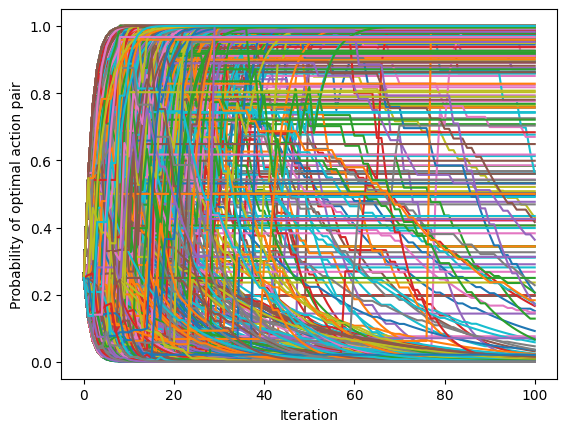

In [240]:
for trace in op_action_trace['optimal']:
  plt.plot(range(len(trace)), trace)

plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

# plt.savefig('optimal_convergence.png', bbox_inches='tight')
plt.show()

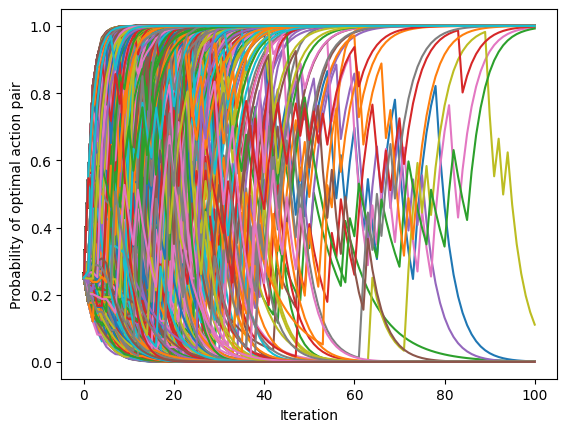

In [26]:
for trace in op_action_trace['local_fair']:
  plt.plot(range(len(trace)), trace)

plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

# plt.savefig('local_fair_convergence.png', bbox_inches='tight')
plt.show()

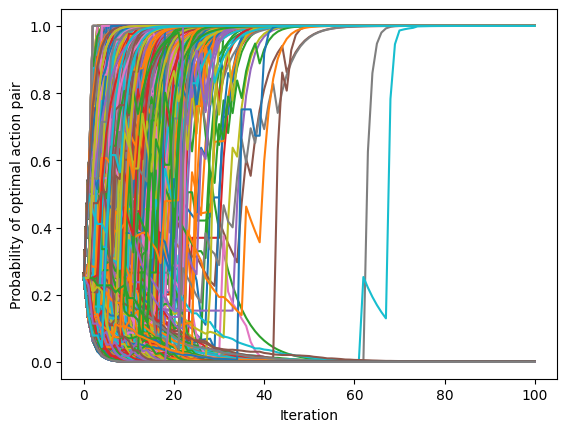

In [277]:
for trace in op_action_trace['reward_related_local_fair']:
  plt.plot(range(len(trace)), trace)

plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

# plt.savefig('reward_related_local_fair_convergence.png', bbox_inches='tight')
plt.show()

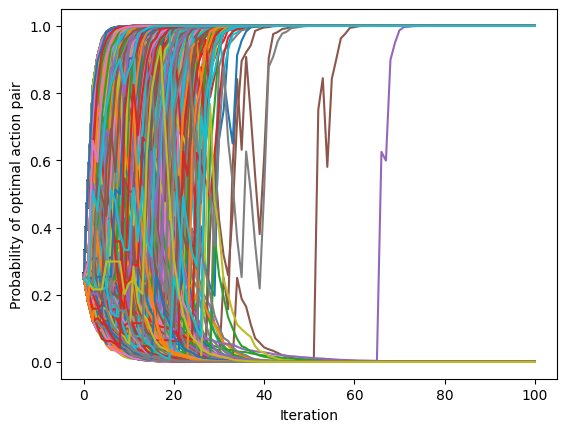

In [28]:
for trace in op_action_trace['global_fair']:
  plt.plot(range(len(trace)), trace)

plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

# plt.savefig('global_fair_convergence.png', bbox_inches='tight')
plt.show()

#### Optimality

In [27]:
JA_op_mean = np.mean(op_action_JA, axis=0)
# IL_op_mean = np.mean(IL_op_trace, axis=0)

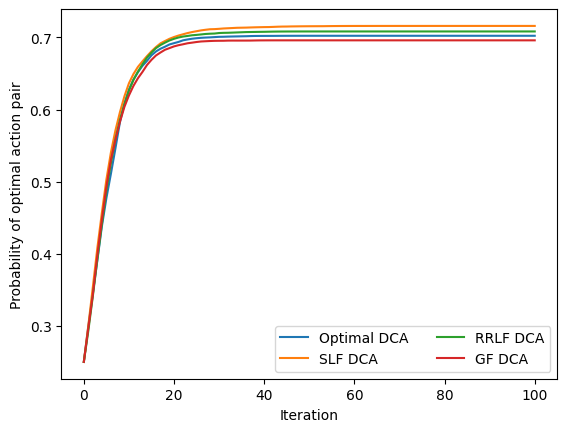

In [60]:
types_name = {"optimal":"Optimal", "local_fair": "SLF", "global_fair": "GF", "reward_related_local_fair":"RRLF", "random":"Random", "still":'Still'}
test_types = ["optimal","local_fair", "reward_related_local_fair", 'global_fair']
mean_value = {'JAL' : 0, 'SNE': 0, 'MNE': 0, 'NNE': 0, "random": 0, "optimal": 0,"local_fair": 0, "reward_related_local_fair": 0, "global_fair": 0}

for name in test_types:
  DCA_op_mean = np.mean(np.array(op_action_trace[name]), axis=0)
  # mean_value[name] = DCA_op_mean[-1]
  plt.plot(range(len(DCA_op_mean)), DCA_op_mean, label=types_name[name]+" DCA")


# plt.plot(range(len(JA_op_mean)), JA_op_mean, label="JAL")
# mean_value['JAL'] = JA_op_mean[-1]

# for name in IL_test_games:
#   IL_op_mean = np.mean(np.array(IL_op_trace[name]), axis=0)
#   mean_value[name] = IL_op_mean[-1]
#   plt.plot(range(len(IL_op_mean)), IL_op_mean, label='IL with '+name)

  # plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

plt.legend(ncol=2)

plt.savefig('Comparison_all_g1.png', bbox_inches='tight')
# plt.show()

In [27]:
print(mean_value)

{'JAL': 0.7906666831705965, 'SNE': 0.778333333333334, 'MNE': 0.7093333333333334, 'NNE': 0.6296666667020511, 'random': 0.6993335042418788, 'optimal': 0.7099983106641763, 'local_fair': 0.7066643957374277, 'reward_related_local_fair': 0.7093333328730275, 'global_fair': 0.7143333333925271}


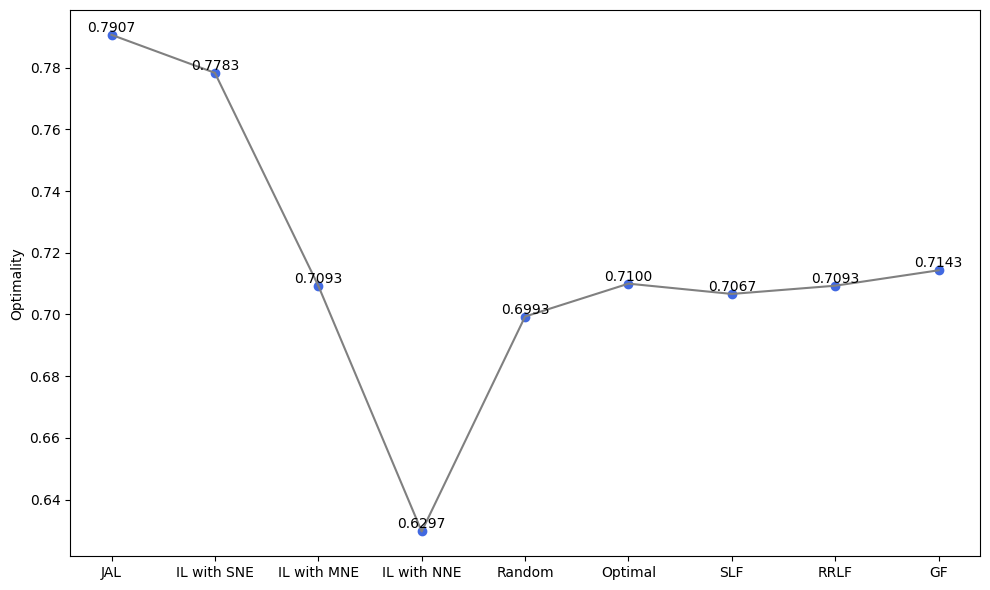

In [35]:
# Extract keys and values from the dictionary
keys = ['JAL', 'IL with SNE', 'IL with MNE', 'IL with NNE', 'Random', 'Optimal', 'SLF', 'RRLF', 'GF']
values = list(mean_value.values())

# Create a bar plot
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
# bars = plt.bar(keys, values, color='royalblue')
plt.scatter(keys, values, color='royalblue')

# Add labels for each bar
# for bar, value in zip(bars, values):
#     plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.4f}', ha='center', va='bottom')
for key, value in zip(keys, values):
    plt.text(key, value, f'{value:.4f}', ha='center', va='bottom')

plt.plot(keys, values, linestyle='-', color='gray', marker='', markersize=2)


# Set axis labels and a title
# plt.xlabel('Categories')
plt.ylabel('Optimality')
# plt.title('Mean Values for Categories')

# Rotate x-axis labels for better visibility
plt.xticks()

# Show the plot
plt.tight_layout()
# plt.show()
plt.savefig('Comparison_all_g1_values.png', bbox_inches='tight')


## Experiment 2 - Reward Table Transformation

Filter Success

In [154]:
success_idx ={"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[]}
test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]

for name in test_types:
  success_idx[name] = [i for i,subtrace in enumerate(op_action_trace[name]) if subtrace[-1]>=0.99]

### Results

In [155]:
def reward_transformation(designer_name, id_idx = 0):
  print(len(success_idx[designer_name]))

  id = success_idx[designer_name][id_idx]
  # print('Agent 1 policy: ' + str(agent1_policy[designer_name][id]))
  # print('Agent 2 policy: ' + str(agent2_policy[designer_name][id]))
  # print('Agent 1 reward: ' + str(agent1_single_reward[designer_name][id]))
  # print('Agent 2 reward: ' + str(agent2_single_reward[designer_name][id]))

  print('Local fairness: ' + str(local_fairness[designer_name][id]))
  print('Designer choice: ' + str(designer_choice[designer_name][id]))
  designer_choices = set(designer_choice[designer_name][id])
  print(designer_choices)

  reward = game_rewards1
  for idx, alloc_idx in enumerate(designer_choices):
    alloc = op_full_alloc[alloc_idx]
    print('Alloc', alloc_idx, ':')
    print(alloc)
    print(np.array(alloc)*reward)
    print((1-np.array(alloc))*reward)

  print()
  print(local_fairness[designer_name][id][-1])
  print(designer_choice[designer_name][id][-1])

In [156]:
# test_types = ["optimal", "local_fair", "reward_related_local_fair"]

reward_transformation("optimal", 2)

710
Local fairness: [0.9682458365518543, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386]
Designer choice: [293, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]
{33, 293}
Alloc 33 :
[[0.25, 0.375], [0.375, 0.625]]
[[5.   3.75]
 [3.   8.75]]
[[15.    6.25]
 [ 5.    5.25]]
Alloc 293 :
[[0.5, 0.375], [0.625, 0.625]]
[[10.    3.75]
 [ 5.    8.75]]
[[10.    6.25]
 [ 3.    5.25]]

0.8660254037844386
33


## Experiment 3 - Action space

### Train

#### DCA

In [ ]:
def train_DCA_actions(game_rewards, test_types, action_sets, total_game_num = 1000, iter_num = 100):
  for designer_type in test_types:
    test_game = Game(game_rewards)
    print(designer_type)
    for idx, action_set in enumerate(action_sets):
      op_full_alloc = [[[a,b],[c,d]] for a in action_set for b in action_set for c in action_set for d in action_set]
      print(idx, action_set)

      for i in range(total_game_num):
        test_designer = Designer(action_set, op_full_alloc, 2, designer_type)
        test_agent1 = Agent(agent1_action)
        test_agent2 = Agent(agent2_action)

        test = Cross_Learning_Playground(test_designer, [test_agent1, test_agent2], test_game, iter_num)
        test.train()

        p1a1 = np.array(test.agents[0].policy_trace[0])
        p2a1 = np.array(test.agents[1].policy_trace[0])
        op_action = p1a1*p2a1
        op_action_trace3[designer_type][idx].append(op_action)

        agent1_policy3[designer_type][idx].append(test.agents[0].policy_trace)
        agent2_policy3[designer_type][idx].append(test.agents[1].policy_trace)
        designer_choice3[designer_type][idx].append(test.designer.choice_trace)

        local_fairness3[designer_type][idx].append(test.designer.local_fairness_trace)
        r_local_fairness3[designer_type][idx].append(test.designer.r_local_fairness_trace)
        global_fairness3[designer_type][idx].append(test.designer.global_fairness_trace)

        agent1_reward3[designer_type][idx].append(test.agents[0].reward_trace)
        agent2_reward3[designer_type][idx].append(test.agents[1].reward_trace)
        designer_policy3[designer_type][idx].append(test.designer.policy_trace)

        agent1_single_reward3[designer_type][idx].append(test.agents[0].single_reward_trace)
        agent2_single_reward3[designer_type][idx].append(test.agents[1].single_reward_trace)

        normalised_reward3[designer_type][idx].append(test.normalised_reward_trace)
        # agent2_normalised_reward3[designer_type][idx].append(test.agents[1].normalised_reward_trace)

        first_action_pairs3[designer_type][idx].append(test.first_actions)


In [ ]:
op_action_trace3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
local_fairness3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
r_local_fairness3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
global_fairness3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
agent1_reward3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
agent2_reward3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
designer_policy3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}

agent1_single_reward3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
agent2_single_reward3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}

agent1_policy3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
agent2_policy3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
designer_choice3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}

first_action_pairs3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}

normalised_reward3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
# agent1_normalised_reward3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
# agent2_normalised_reward3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}
first_action_pairs3 = {"local_fair": {0:[],1:[],2:[],3:[]},"reward_related_local_fair": {0:[],1:[],2:[],3:[]}}

test_types3 = ["local_fair", "reward_related_local_fair"]
test_action_sets = [[1/2], [1/4, 1/2, 3/4], [1/4, 3/8, 1/2, 5/8, 3/4], [0, 1/4, 3/8, 1/2, 5/8, 3/4,1]]

train_DCA_actions(game_rewards1, test_types3, test_action_sets, 3000, 100)

local_fair
0 [0.5]
1 [0.25, 0.5, 0.75]
2 [0.25, 0.375, 0.5, 0.625, 0.75]
3 [0, 0.25, 0.375, 0.5, 0.625, 0.75, 1]
reward_related_local_fair
0 [0.5]
1 [0.25, 0.5, 0.75]
2 [0.25, 0.375, 0.5, 0.625, 0.75]
3 [0, 0.25, 0.375, 0.5, 0.625, 0.75, 1]


#### IL

IL train

In [ ]:
def IL_train(game_reward, total_game_num = 1000, iter_num = 100):
  test_game = IL_Game(game_reward)
  for i in range(total_game_num):
    test_agent1 = Agent(agent1_action)
    test_agent2 = Agent(agent2_action)

    test = Independent_Learning_Playground([test_agent1, test_agent2], test_game, iter_num)
    test.train()

    IL_p1a1 = np.array(test.agents[0].policy_trace[0])
    IL_p2a1 = np.array(test.agents[1].policy_trace[0])
    IL_op_trace.append(IL_p1a1*IL_p2a1)

    IL_agent1_policy.append(IL_p1a1)
    IL_agent2_policy.append(IL_p2a1)

    IL_agent1_single_reward.append(test.agents[0].single_reward_trace)
    IL_agent2_single_reward.append(test.agents[1].single_reward_trace)

    IL_normalised_reward.append(test.normalised_reward_trace)


In [ ]:
IL_op_trace = []

IL_agent1_policy = []
IL_agent2_policy = []

IL_agent1_single_reward = []
IL_agent2_single_reward = []

IL_normalised_reward = []

IL_train(IL_game_rewards1, 3000)

### Results

In [ ]:
IL_op_mean = np.mean(IL_op_trace, axis=0)

#### Overall

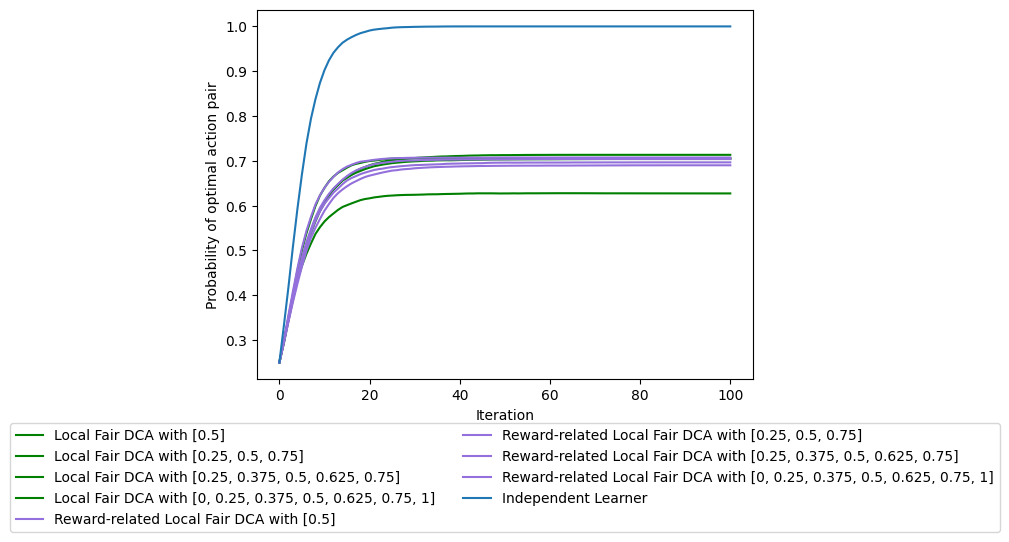

In [ ]:
types_name = ["Local Fair", "Reward-related Local Fair"]
color = {'local_fair': 'green', 'reward_related_local_fair':'mediumpurple'}
for i, name in enumerate(test_types3):
  for j, action_set in enumerate(test_action_sets):
    DCA_op_mean = np.mean(np.array(op_action_trace3[name][j]), axis=0)
    plt.plot(range(len(DCA_op_mean)), DCA_op_mean, color = color[name], label=types_name[i]+" DCA with "+ str(action_set))

plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# plt.savefig('local_fair_actions_comparison.png', bbox_inches='tight')
plt.show()

#### Reward-related Local Fair

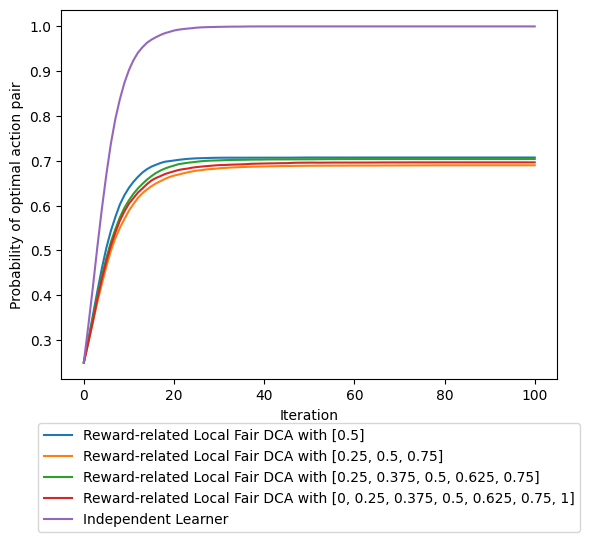

In [ ]:
for j, action_set in enumerate(test_action_sets):
  DCA_op_mean = np.mean(np.array(op_action_trace3['reward_related_local_fair'][j]), axis=0)
  plt.plot(range(len(DCA_op_mean)), DCA_op_mean, label="Reward-related Local Fair DCA with "+ str(action_set))

plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)

plt.show()

#### Local Fair

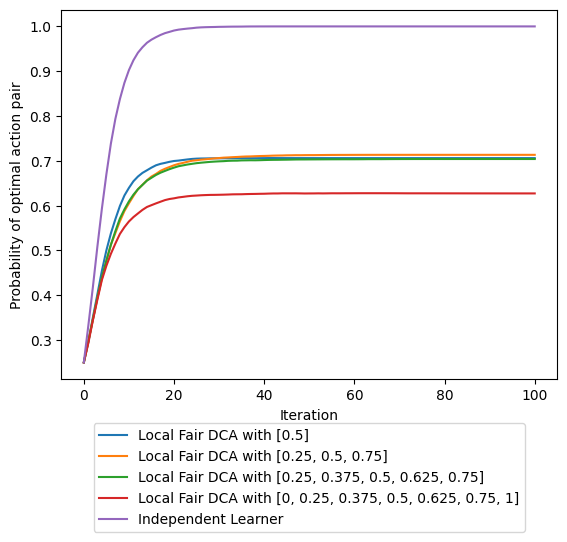

In [ ]:
for j, action_set in enumerate(test_action_sets):
  DCA_op_mean = np.mean(np.array(op_action_trace3['local_fair'][j]), axis=0)
  plt.plot(range(len(DCA_op_mean)), DCA_op_mean, label="Local Fair DCA with "+ str(action_set))

plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)

# plt.savefig('rrlf_actions_comparison.png', bbox_inches='tight')
plt.show()

## Experiment 4

*   Initial action - Convergend action (DIfferent intial action -> probability to converge optimal actions)
*   Failed Initial action - Convergend action (Failed converge - what are they converged?)
*   LF and RRLF
*   凸显度 (high -> higher optimality, easier to learn without learning suboptimality)
*   why LF suffers unconverge at (0,1) / (1,0)?
*   
*   local fairness
*   global fairness
*   stability (Single NE, Multi NE, Not NE)



## Experiment 4 - order of convergence

In [45]:
converge_types = ["optimal","local_fair", "reward_related_local_fair"]

fail_idx = {"optimal":[], "local_fair": [], "reward_related_local_fair": []}

designer_choice_fail = {"optimal":[], "local_fair": [], "reward_related_local_fair": []}
agent1_policy_fail = {"optimal":[], "local_fair": [], "reward_related_local_fair":[]}
agent2_policy_fail = {"optimal":[], "local_fair": [], "reward_related_local_fair":[]}

for name in converge_types:
  fail_idx[name] = [i for i,subtrace in enumerate(op_action_trace[name]) if subtrace[-1]<0.99]
  designer_choice_fail[name] = [designer_choice[name][i] for i in fail_idx[name]]
  agent1_policy_fail[name] = [agent1_policy[name][i] for i in fail_idx[name]]
  agent2_policy_fail[name] = [agent2_policy[name][i] for i in fail_idx[name]]



Converge speed in DCAs

In [46]:
# opt_designer_choice = designer_choice['optimal']
designer_converge_iter = {"optimal":[], "local_fair": [],"reward_related_local_fair":[]}

test_types = ["optimal","local_fair", "reward_related_local_fair"]

for name in test_types:
  for trace in designer_choice_fail[name]:
    a = np.where(np.diff(np.array(trace)[::-1]) != 0)

    if len(a[0]) == 0:
      a = len(trace)-1
    else:
      a = a[0][0]

    choice_converge_index = len(trace) - a
    if name == 'optimal':
      choice_converge_index = 1+(choice_converge_index-1)*OPTIMAL_INTERNEL_SIZE
    designer_converge_iter[name].append(choice_converge_index)

In [47]:
print(designer_converge_iter['local_fair'])

[1, 3, 21, 2, 1, 5, 8, 2, 1, 70, 4, 3, 9, 8, 7, 3, 69, 1, 1, 3, 2, 6, 2, 8, 2, 25, 83, 2, 9, 1, 9, 3, 4, 6, 2, 2, 3, 10, 5, 5, 2, 1, 1, 5, 100, 1, 12, 1, 1, 7, 6, 3, 7, 9, 1, 1, 53, 1, 14, 17, 6, 4, 3, 4, 1, 1, 7, 2, 5, 1, 1, 1, 2, 1, 5, 8, 2, 1, 8, 1, 6, 1, 3, 2, 6, 1, 4, 1, 9, 54, 1, 1, 1, 11, 1, 26, 29, 1, 2, 1, 3, 2, 1, 78, 3, 1, 5, 3, 3, 7, 2, 1, 5, 4, 4, 6, 8, 1, 5, 2, 3, 2, 2, 1, 1, 1, 3, 7, 8, 1, 13, 1, 1, 3, 22, 1, 4, 7, 9, 10, 5, 3, 1, 22, 3, 1, 4, 1, 2, 2, 2, 1, 1, 11, 15, 1, 1, 1, 2, 4, 19, 5, 12, 1, 1, 1, 8, 3, 5, 1, 2, 2, 1, 17, 19, 61, 1, 8, 1, 1, 1, 100, 1, 54, 11, 6, 63, 2, 37, 49, 10, 9, 44, 2, 3, 7, 9, 2, 1, 2, 2, 1, 4, 1, 6, 1, 7, 20, 3, 3, 6, 2, 15, 7, 100, 1, 2, 1, 4, 6, 1, 1, 2, 12, 3, 3, 4, 87, 2, 2, 1, 2, 4, 1, 3, 1, 3, 1, 1, 2, 21, 5, 1, 4, 4, 4, 34, 6, 4, 3, 3, 3, 2, 16, 1, 20, 9, 3, 4, 4, 4, 1, 4, 1, 8, 1, 63, 4, 1, 8, 3, 13, 4, 5, 1, 1, 97, 2, 1, 6, 22, 60, 1, 23, 3, 2, 4, 5, 2, 1, 3, 3, 5, 2, 4, 2, 2, 7, 1, 5, 1, 5, 5, 24, 7, 3, 5, 13, 98, 7, 2, 52, 11, 3,

In [48]:
# opt_designer_choice = designer_choice['optimal']
agent1_converge_iter = {"optimal":[], "local_fair": [], "reward_related_local_fair":[]}
agent2_converge_iter = {"optimal":[], "local_fair": [], "reward_related_local_fair":[]}

test_types = ["optimal","local_fair", "reward_related_local_fair"]

for name in test_types:
  for i in range(len(agent1_policy_fail[name])):
    a1_p0 = np.array(agent1_policy_fail[name][i][0])
    a2_p0 = np.array(agent2_policy_fail[name][i][0])
    idx1 = 0
    idx2 = 0

    if a1_p0[-1] > 0.99:
      idx1 = np.where(a1_p0 > 0.99)[0][0]
    elif a1_p0[-1] <0.01:
      idx1 = np.where(a1_p0 < 0.01)[0][0]
    else:
      idx1 = np.where(np.diff(a1_p0[::-1]) != 0)[0][-1]+1

    if a2_p0[-1] > 0.99:
      idx2 = np.where(a2_p0 > 0.99)[0][0]
    elif a2_p0[-1] <0.01:
      idx2 = np.where(a2_p0 < 0.01)[0][0]
    else:
      idx2 = np.where(np.diff(a2_p0[::-1]) != 0)[0][-1]+1

    agent1_converge_iter[name].append(idx1)
    agent2_converge_iter[name].append(idx2)

In [49]:
convergence_order = {"optimal":[0,0,0],
                     "local_fair": [0,0,0],
                     "reward_related_local_fair":[0,0,0]}

converge_types = ["optimal","local_fair", "reward_related_local_fair"]
for name in converge_types:
  for i in range(len(designer_converge_iter[name])):
    d, p1, p2 = designer_converge_iter[name][i], agent1_converge_iter[name][i], agent2_converge_iter[name][i]

    # print(name)
    # print(i, d, p1, p2)
    if d <= p1 and d<= p2:
      convergence_order[name][0]+=1
    elif (d>p1 and d <= p2) or (d>p2 and d <= p1):
      convergence_order[name][1]+=1
    elif d>p1 and d > p2:
      convergence_order[name][2]+=1
    else:
      print('??', name, i, d, p1, p2)
      break
    # break

In [50]:
print(convergence_order)

{'optimal': [3, 0, 890], 'local_fair': [774, 15, 63], 'reward_related_local_fair': [22, 0, 853]}


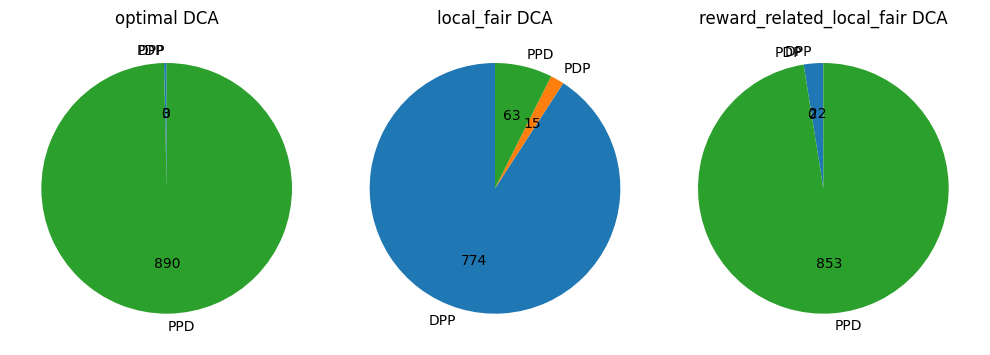

In [51]:
num_rows = 1
num_cols = 3
num_charts = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i, name in enumerate(converge_types):

    # values = list(frequency_dict.values())
    labels = ['DPP', 'PDP', 'PPD']

    axs[i].pie(convergence_order[name], labels=labels,  autopct=lambda p: f'{p * sum(convergence_order[name]) / 100:.0f}', startangle=90)
    axs[i].set_title(name+" DCA")

plt.tight_layout()

plt.savefig('convergence_dpp.png')
# plt.show()

Full cases

In [52]:
# opt_designer_choice = designer_choice['optimal']
designer_converge_iter = {"optimal":[], "local_fair": [],"reward_related_local_fair":[]}

test_types = ["optimal","local_fair", "reward_related_local_fair"]

for name in test_types:
  for trace in designer_choice[name]:
    a = np.where(np.diff(np.array(trace)[::-1]) != 0)

    if len(a[0]) == 0:
      a = len(trace)-1
    else:
      a = a[0][0]
    choice_converge_index = len(trace) - a
    if name == 'optimal':
      choice_converge_index = 1+(choice_converge_index-1)*OPTIMAL_INTERNEL_SIZE
    designer_converge_iter[name].append(choice_converge_index)

In [53]:
print(designer_converge_iter['local_fair'])

[1, 1, 100, 3, 21, 2, 2, 3, 3, 99, 1, 2, 1, 5, 1, 1, 26, 18, 1, 6, 2, 5, 4, 5, 6, 2, 6, 8, 3, 9, 3, 2, 2, 1, 1, 2, 70, 8, 4, 15, 3, 4, 36, 1, 2, 9, 8, 9, 4, 3, 6, 3, 11, 9, 1, 1, 5, 7, 4, 5, 7, 9, 100, 3, 1, 16, 69, 1, 5, 1, 2, 10, 100, 3, 4, 5, 4, 2, 3, 3, 85, 30, 6, 1, 3, 2, 10, 2, 6, 1, 1, 6, 1, 10, 5, 2, 8, 2, 6, 1, 7, 99, 2, 25, 1, 2, 83, 1, 2, 11, 1, 2, 1, 9, 1, 17, 4, 3, 2, 3, 9, 3, 1, 9, 4, 3, 5, 4, 25, 5, 3, 3, 2, 23, 1, 2, 3, 6, 25, 9, 2, 1, 2, 2, 3, 11, 3, 10, 19, 81, 11, 6, 5, 8, 50, 2, 13, 1, 5, 1, 6, 7, 1, 3, 6, 4, 2, 2, 1, 1, 4, 1, 1, 6, 5, 100, 1, 9, 1, 2, 5, 5, 2, 12, 1, 76, 1, 61, 6, 16, 96, 33, 8, 2, 1, 6, 1, 2, 1, 41, 18, 7, 5, 13, 6, 3, 21, 8, 3, 7, 1, 6, 9, 1, 2, 2, 1, 1, 53, 4, 1, 98, 27, 4, 83, 3, 74, 8, 3, 1, 17, 14, 9, 10, 3, 16, 1, 3, 17, 1, 1, 6, 4, 1, 4, 3, 1, 4, 3, 1, 4, 5, 5, 4, 3, 2, 1, 1, 30, 6, 21, 7, 3, 2, 5, 3, 19, 5, 1, 1, 7, 3, 10, 9, 1, 2, 1, 2, 8, 11, 21, 2, 1, 5, 11, 7, 2, 3, 2, 6, 1, 4, 4, 8, 2, 1, 1, 15, 25, 1, 5, 2, 1, 1, 3, 4, 1, 4, 6, 2, 1,

In [54]:
# opt_designer_choice = designer_choice['optimal']
agent1_converge_iter = {"optimal":[], "local_fair": [], "reward_related_local_fair":[]}
agent2_converge_iter = {"optimal":[], "local_fair": [], "reward_related_local_fair":[]}

test_types = ["optimal","local_fair", "reward_related_local_fair"]

for name in test_types:
  for i in range(len(agent1_policy[name])):
    a1_p0 = np.array(agent1_policy[name][i][0])
    a2_p0 = np.array(agent2_policy[name][i][0])
    idx1 = 0
    idx2 = 0

    if a1_p0[-1] > 0.99:
      idx1 = np.where(a1_p0 > 0.99)[0][0]
    elif a1_p0[-1] <0.01:
      idx1 = np.where(a1_p0 < 0.01)[0][0]
    else:
      idx1 = np.where(np.diff(a1_p0[::-1]) != 0)[0][-1]+1

    if a2_p0[-1] > 0.99:
      idx2 = np.where(a2_p0 > 0.99)[0][0]
    elif a2_p0[-1] <0.01:
      idx2 = np.where(a2_p0 < 0.01)[0][0]
    else:
      idx2 = np.where(np.diff(a2_p0[::-1]) != 0)[0][-1]+1

    agent1_converge_iter[name].append(idx1)
    agent2_converge_iter[name].append(idx2)

In [55]:
print(agent1_converge_iter['reward_related_local_fair'][6])
print(agent2_converge_iter['reward_related_local_fair'][6])
print(designer_converge_iter['reward_related_local_fair'][6])

d, p1, p2 = designer_converge_iter['reward_related_local_fair'][6], agent1_converge_iter['reward_related_local_fair'][6], agent2_converge_iter['reward_related_local_fair'][6]
if d <= p1 and d<= p2:
  print('1')
elif (d>p1 and d <= p2) or (d>p2 and d <= p1):
  print('2')
  print(int(d>p1))
  print(d>p2 and d <= p1)
elif d>p1 and d > p2:
  print('3')
else:
  print('??', d, p1, p2)


14
15
100
3


In [56]:
convergence_order = {"optimal":[0,0,0],
                     "local_fair": [0,0,0],
                     "reward_related_local_fair":[0,0,0]}

converge_types = ["optimal","local_fair", "reward_related_local_fair"]
for name in converge_types:
  for i in range(len(designer_converge_iter[name])):
    d, p1, p2 = designer_converge_iter[name][i], agent1_converge_iter[name][i], agent2_converge_iter[name][i]

    # print(name)
    # print(i, d, p1, p2)
    if d <= p1 and d<= p2:
      convergence_order[name][0]+=1
    elif (d>p1 and d <= p2) or (d>p2 and d <= p1):
      convergence_order[name][1]+=1
    elif d>p1 and d > p2:
      convergence_order[name][2]+=1
    else:
      print('??', name, i, d, p1, p2)
      break
    # break

In [57]:
print(convergence_order)

{'optimal': [1973, 133, 894], 'local_fair': [2405, 142, 453], 'reward_related_local_fair': [1896, 197, 907]}


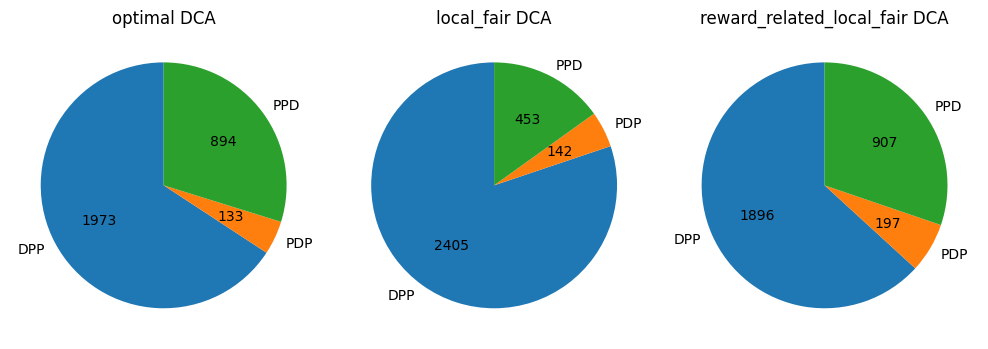

In [58]:
num_rows = 1
num_cols = 3
num_charts = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i, name in enumerate(converge_types):

    # values = list(frequency_dict.values())
    labels = ['DPP', 'PDP', 'PPD']

    axs[i].pie(convergence_order[name], labels=labels,  autopct=lambda p: f'{p * sum(convergence_order[name]) / 100:.0f}', startangle=90)
    axs[i].set_title(name+" DCA")

plt.tight_layout()

plt.savefig('convergence_dpp.png')
# plt.show()

## Experiment 5 - Random = IL with expected reward

IL

In [62]:
IL_expected_reward1 = np.array([[[0.5,0.5], [0,0]],
                                [[7/64,7/64], [1/16,1/16]]])


IL_expected_reward2 = np.array([[[0.5,0.5], [0,0]],
                                [[0,0], [1/4,1/4]]])

# IL_expected_reward3 = np.array([[[0.5,0.5], [1/4,1/4]],
#                                 [[1/4,1/4], [0,0]]])

IL_expected_reward3 = np.array([[[0.3,0.7], [1/20,7/60]],
                                [[0,0], [3/20,7/20]]])

# IL_expected_reward3 = np.array([[[0.5,0.5], [1/4,1/4]],
#                                 [[1/4,1/4], [0,0]]])

In [63]:
IL_op_trace = {'G1':[], 'G2':[], 'G3':[]}

IL_agent1_policy = {'G1':[], 'G2':[], 'G3':[]}
IL_agent2_policy = {'G1':[], 'G2':[], 'G3':[]}

IL_agent1_single_reward = {'G1':[], 'G2':[], 'G3':[]}
IL_agent2_single_reward = {'G1':[], 'G2':[], 'G3':[]}

IL_normalised_reward = {'G1':[], 'G2':[], 'G3':[]}

# IL_test_games = {'SNE':IL_expected_reward1, 'MNE':IL_expected_reward2, 'NNE':IL_expected_reward3}
IL_test_games = {'G1':IL_expected_reward1, 'G2':IL_expected_reward2, 'G3': IL_expected_reward3}

IL_train(IL_test_games, 3000)

G1
G2
G3


Random DCA

In [64]:
game_rewards1 = np.array([[200, 40],
                          [70, 60]])

game_rewards2 = np.array([[4, 0],
                          [0, 2]])

game_rewards3 = np.array([[20, 10],
                          [8, 14]])

# op_single_alloc = [0.1, 0.2, 0.3, 0.4, 0.5]
# op_full_alloc = [[[a,b],[c,d]] for a in op_single_alloc for b in op_single_alloc for c in op_single_alloc for d in op_single_alloc]


In [39]:
def train_DCA_games(game_rewards, test_types, total_game_num = 1000, iter_num = 100):
  for name, game in game_rewards.items():
    for designer in test_types:
      test_game = Game(game)
      print(game)
      print(designer)
      for i in range(total_game_num):
        test_designer = Designer(single_alloc[designer], full_alloc[designer], 2, designer)
        test_agent1 = Agent(agent1_action)
        test_agent2 = Agent(agent2_action)

        test = Cross_Learning_Playground(test_designer, [test_agent1, test_agent2], test_game, iter_num)
        test.train()

        p1a1 = np.array(test.agents[0].policy_trace[0])
        p2a1 = np.array(test.agents[1].policy_trace[0])
        op_action = p1a1*p2a1
        op_action_trace_full[name][designer].append(op_action)

        agent1_policy_full[name][designer].append(test.agents[0].policy_trace)
        agent2_policy_full[name][designer].append(test.agents[1].policy_trace)
        designer_choice_full[name][designer].append(test.designer.choice_trace)

        local_fairness_full[name][designer].append(test.designer.local_fairness_trace)
        r_local_fairness_full[name][designer].append(test.designer.r_local_fairness_trace)
        global_fairness_full[name][designer].append(test.designer.global_fairness_trace)

        agent1_reward_full[name][designer].append(test.agents[0].reward_trace)
        agent2_reward_full[name][designer].append(test.agents[1].reward_trace)
        designer_policy_full[name][designer].append(test.designer.policy_trace)

        agent1_single_reward_full[name][designer].append(test.agents[0].single_reward_trace)
        agent2_single_reward_full[name][designer].append(test.agents[1].single_reward_trace)

        first_action_pairs_full[name][designer].append(test.first_actions)
        agent1_policy_choice_full[name][designer].append(test.agents[0].policy_choice_trace)
        agent2_policy_choice_full[name][designer].append(test.agents[1].policy_choice_trace)

    # op_action_trace_full[name] = op_action_trace.copy()

    # agent1_policy_full[name] = agent1_policy.copy()
    # agent2_policy_full[name]=agent2_policy.copy()
    # designer_choice_full[name]=designer_choice.copy()

    # local_fairness_full[name]=local_fairness.copy()
    # r_local_fairness_full[name]=r_local_fairness.copy()
    # global_fairness_full[name]=global_fairness.copy()

    # agent1_reward_full[name]=agent1_reward.copy()
    # agent2_reward_full[name]=agent2_reward.copy()
    # designer_policy_full[name]=designer_policy.copy()

    # agent1_single_reward_full[name]=agent1_single_reward.copy()
    # agent2_single_reward_full[name]=agent2_single_reward.copy()

    # first_action_pairs_full[name]=first_action_pairs.copy()
    # agent1_policy_choice_full[name]=agent1_policy_choice.copy()
    # agent2_policy_choice_full[name]=agent2_policy_choice.copy()

In [99]:
op_action_trace5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
local_fairness5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[]}
r_local_fairness5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[]}
global_fairness5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
agent1_reward5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
agent2_reward5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
designer_policy5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}

agent1_single_reward5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
agent2_single_reward5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}

agent1_policy5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
agent2_policy5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
designer_choice5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}

first_action_pairs5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
agent1_policy_choice5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}
agent2_policy_choice5 = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}


In [66]:
op_action_trace_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
local_fairness_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
r_local_fairness_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
global_fairness_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
agent1_reward_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
agent2_reward_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
designer_policy_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}

agent1_single_reward_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
agent2_single_reward_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}

agent1_policy_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
agent2_policy_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
designer_choice_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}

first_action_pairs_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
agent1_policy_choice_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}
agent2_policy_choice_full = {"G1":{"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G2": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]},
                        "G3": {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair":[], "random":[]}}

# test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]
test_types = ["random"]

# test_types = ["random"]
# test_games = {"G1":game_rewards1, "G2":game_rewards2, "G3":game_rewards3}
test_games = {"G1":game_rewards1, "G2":game_rewards2, 'G3': game_rewards3}

train_DCA_games(test_games, test_types, 3000, 100)

[[200  40]
 [ 70  60]]
random
[[4 0]
 [0 2]]
random
[[20 10]
 [ 8 14]]
random


In [47]:
def re_train_game(test_game, game_name, test_type):

  op_action_trace_full[game_name][test_type] = []
  local_fairness_full [game_name][test_type] = []
  r_local_fairness_full[game_name][test_type] = []
  global_fairness_full[game_name][test_type] = []
  agent1_reward_full[game_name][test_type] = []
  agent2_reward_full[game_name][test_type] = []
  designer_policy_full[game_name][test_type] = []
  agent1_single_reward_full[game_name][test_type] = []
  agent2_single_reward_full [game_name][test_type] = []

  agent1_policy_full[game_name][test_type] = []
  agent2_policy_full[game_name][test_type] = []
  designer_choice_full[game_name][test_type] = []
  first_action_pairs_full[game_name][test_type] = []
  agent1_policy_choice_full[game_name][test_type] = []
  agent2_policy_choice_full[game_name][test_type] = []

  train_DCA_games(test_game, [test_type], 3000, 100)

In [48]:
test_games = {"G3":game_rewards1}
re_train_game(test_games, 'G3', 'random')

[[20 10]
 [ 8 14]]
random


Plot

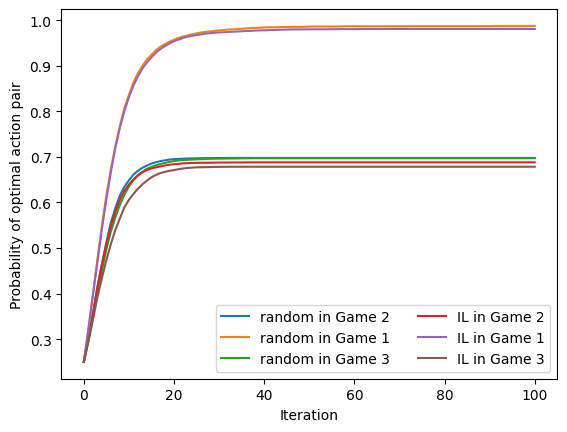

In [61]:
types_name = {"G1":"Game 1", "G2": "Game 2", "G3": "Game 3"}
color = {'DCA': 'green', 'IL':'royalblue'}
# test_games = {"G1":game_rewards2, "G2":game_rewards3}
# IL_test_games = {'G1':IL_expected_reward1, 'G2':IL_expected_reward2}

test_games = {"G1":game_rewards2, "G2":game_rewards3, 'G3': game_rewards1}
IL_test_games = {'G1':IL_expected_reward1, 'G2':IL_expected_reward2, 'G3': IL_expected_reward3}

mean_values = []



for name, reward in test_games.items():
  for designer in test_types:
    DCA_op_mean = np.mean(np.array(op_action_trace_full[name][designer]), axis=0)
    mean_values.append(DCA_op_mean[-1])
    plt.plot(range(len(DCA_op_mean)), DCA_op_mean, label=designer+' in ' +types_name[name])

for i,name in enumerate(IL_test_games):
  IL_op_mean = np.mean(np.array(IL_op_trace[name]), axis=0)
  mean_values.append(IL_op_mean[-1])
  plt.plot(range(len(IL_op_mean)), IL_op_mean, label='IL'+' in ' +types_name[name])

  # plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

plt.legend( ncol=2)

plt.savefig('comparison_random_expected.png', bbox_inches='tight')
# plt.show()

# types_name = {"G1": "Game 1", "G2": "Game 2", "G3": "Game 3"}
# color = {'DCA': 'green', 'IL': 'royalblue'}

# # Create an empty legend
# legend_labels = []

# for name, reward in test_games.items():
#     DCA_op_mean = np.mean(np.array(op_action_trace[name]), axis=0)
#     plt.plot(range(len(DCA_op_mean)), DCA_op_mean, color=color['DCA'])
#     legend_labels.append('Random')  # Add the label to the legend list

# for i, name in enumerate(IL_test_games):
#     IL_op_mean = np.mean(np.array(IL_op_trace[name]), axis=0)
#     plt.plot(range(len(IL_op_mean)), IL_op_mean, color=color['IL'])
#     legend_labels.append('IL')  # Add the label to the legend list

# # Plot labels for the legend only once
# plt.plot([], [], color=color['DCA'], label='Random')
# plt.plot([], [], color=color['IL'], label='IL')

# plt.xlabel('Iteration')
# plt.ylabel('Probability of optimal action pair')

# plt.legend( labels=legend_labels)

# plt.show()


In [54]:
print(mean_values)

[0.6976666666666667, 0.9873342189061464, 0.6970000000000002, 0.688, 0.9806670833403, 0.6783333333333301]


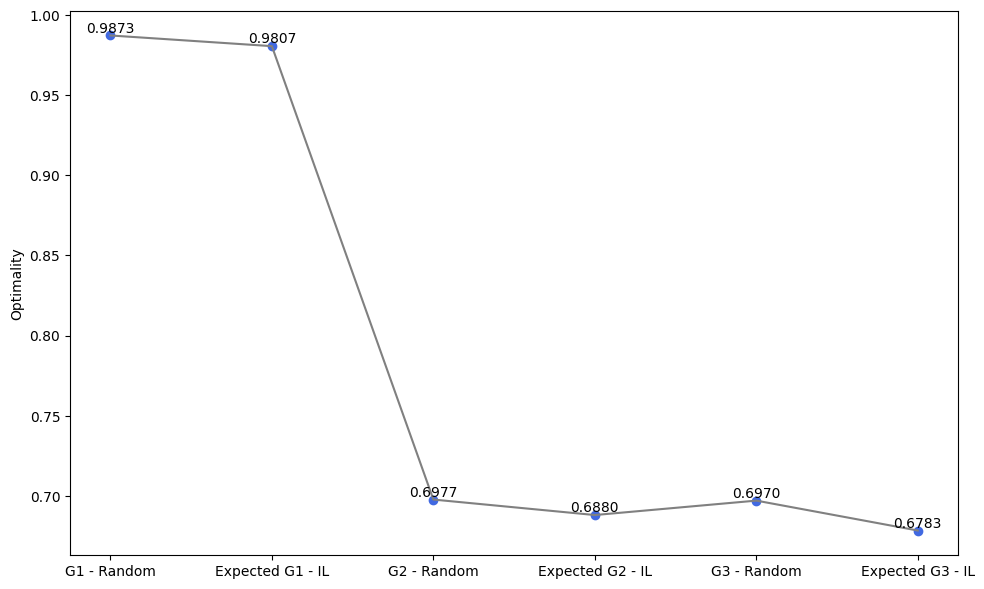

In [59]:
# Extract keys and values from the dictionary
keys = ['G1 - Random', 'Expected G1 - IL', 'G2 - Random', 'Expected G2 - IL', 'G3 - Random', 'Expected G3 - IL']
# values = list(mean_value.values())
values = [0.9873342189061464, 0.9806670833403, 0.6976666666666667, 0.688, 0.6970000000000002, 0.6783333333333301]

# Create a bar plot
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
# bars = plt.bar(keys, values, color='royalblue')
plt.scatter(keys, values, color='royalblue')

# Add labels for each bar
# for bar, value in zip(bars, values):
#     plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.4f}', ha='center', va='bottom')
for key, value in zip(keys, values):
    plt.text(key, value, f'{value:.4f}', ha='center', va='bottom')

plt.plot(keys, values, linestyle='-', color='gray', marker='', markersize=2)


# Set axis labels and a title
# plt.xlabel('Categories')
plt.ylabel('Optimality')
# plt.title('Mean Values for Categories')

# Rotate x-axis labels for better visibility
# plt.xticks(rotation=45)
plt.xticks()

# Show the plot
plt.tight_layout()
# plt.show()
plt.savefig('comparison_random_expected_value.png', bbox_inches='tight')


## Experiment 6 - SNE>MNE>NNE

In [67]:

IL_SNE_G1 = np.array([[[0.5,0.5], [2/15,1/30]],
                      [[0,0], [1/4,1/4]]])

IL_SNE_G2 = np.array([[[0.5,0.5], [1/12,1/12]],
                      [[0,0], [5/14,1/7]]])

IL_SNE_G3 = np.array([[[1/4,3/4], [1/20,7/60]],
                      [[0,0], [5/14,1/7]]])

IL_MNE_G1 = np.array([[[0.5,0.5], [1/12,1/12]],
                      [[0,0], [1/4,1/4]]])

IL_MNE_G2 = np.array([[[1/4,3/4], [7/60,1/20]],
                      [[0,0], [2/7,3/14]]])

IL_MNE_G3 = np.array([[[0.5,0.5], [1/30,2/15]],
                      [[0,0], [2/14,5/14]]])

IL_NNE_G1 = np.array([[[1/4,3/4], [1/12,1/12]],
                      [[0,0], [5/14,1/7]]])

IL_NNE_G2 = np.array([[[3/4,1/4], [1/20,7/60]],
                      [[0,0], [1/4,1/4]]])

IL_NNE_G3 = np.array([[[0,1], [1/12,1/12]],
                      [[0,0], [5/14,1/7]]])



In [68]:
def IL_train(test_games, total_game_num = 1000, iter_num = 100):
  for name, game in test_games.items():
    # print(name)
    for idx, reward in game.items():
      print(name)
      print(reward)
      test_game = IL_Game(reward)
      for i in range(total_game_num):
        test_agent1 = Agent(agent1_action)
        test_agent2 = Agent(agent2_action)

        test = Independent_Learning_Playground([test_agent1, test_agent2], test_game, iter_num)
        test.train()

        IL_p1a1 = np.array(test.agents[0].policy_trace[0])
        IL_p2a1 = np.array(test.agents[1].policy_trace[0])
        IL_op_trace[name][idx].append(IL_p1a1*IL_p2a1)

        IL_agent1_policy[name][idx].append(IL_p1a1)
        IL_agent2_policy[name][idx].append(IL_p2a1)

        IL_agent1_single_reward[name][idx].append(test.agents[0].single_reward_trace)
        IL_agent2_single_reward[name][idx].append(test.agents[1].single_reward_trace)

        IL_normalised_reward[name][idx].append(test.normalised_reward_trace)


In [69]:
IL_op_trace = {'SNE':{'G1':[], 'G2':[], 'G3':[]},
               'MNE':{'G1':[], 'G2':[], 'G3':[]},
               'NNE':{'G1':[], 'G2':[], 'G3':[]}}

IL_agent1_policy = {'SNE':{'G1':[], 'G2':[], 'G3':[]},
               'MNE':{'G1':[], 'G2':[], 'G3':[]},
               'NNE':{'G1':[], 'G2':[], 'G3':[]}}
IL_agent2_policy = {'SNE':{'G1':[], 'G2':[], 'G3':[]},
               'MNE':{'G1':[], 'G2':[], 'G3':[]},
               'NNE':{'G1':[], 'G2':[], 'G3':[]}}

IL_agent1_single_reward = {'SNE':{'G1':[], 'G2':[], 'G3':[]},
               'MNE':{'G1':[], 'G2':[], 'G3':[]},
               'NNE':{'G1':[], 'G2':[], 'G3':[]}}
IL_agent2_single_reward = {'SNE':{'G1':[], 'G2':[], 'G3':[]},
               'MNE':{'G1':[], 'G2':[], 'G3':[]},
               'NNE':{'G1':[], 'G2':[], 'G3':[]}}

IL_normalised_reward = {'SNE':{'G1':[], 'G2':[], 'G3':[]},
               'MNE':{'G1':[], 'G2':[], 'G3':[]},
               'NNE':{'G1':[], 'G2':[], 'G3':[]}}

# IL_test_games = {'SNE':IL_expected_reward1, 'MNE':IL_expected_reward2, 'NNE':IL_expected_reward3}
# IL_test_games = {'G1':IL_expected_reward1, 'G2':IL_expected_reward2, 'G3': IL_expected_reward3}
IL_test_games = {'SNE':{'G1':IL_SNE_G1, 'G2':IL_SNE_G2, 'G3':IL_SNE_G3},
               'MNE':{'G1':IL_MNE_G1, 'G2':IL_MNE_G2, 'G3':IL_MNE_G3},
               'NNE':{'G1':IL_NNE_G1, 'G2':IL_NNE_G2, 'G3':IL_NNE_G3}}

IL_train(IL_test_games, 3000)

SNE
[[[0.5        0.5       ]
  [0.13333333 0.03333333]]

 [[0.         0.        ]
  [0.25       0.25      ]]]
SNE
[[[0.5        0.5       ]
  [0.08333333 0.08333333]]

 [[0.         0.        ]
  [0.35714286 0.14285714]]]
SNE
[[[0.25       0.75      ]
  [0.05       0.11666667]]

 [[0.         0.        ]
  [0.35714286 0.14285714]]]
MNE
[[[0.5        0.5       ]
  [0.08333333 0.08333333]]

 [[0.         0.        ]
  [0.25       0.25      ]]]
MNE
[[[0.25       0.75      ]
  [0.11666667 0.05      ]]

 [[0.         0.        ]
  [0.28571429 0.21428571]]]
MNE
[[[0.5        0.5       ]
  [0.03333333 0.13333333]]

 [[0.         0.        ]
  [0.14285714 0.35714286]]]
NNE
[[[0.25       0.75      ]
  [0.08333333 0.08333333]]

 [[0.         0.        ]
  [0.35714286 0.14285714]]]
NNE
[[[0.75       0.25      ]
  [0.05       0.11666667]]

 [[0.         0.        ]
  [0.25       0.25      ]]]
NNE
[[[0.         1.        ]
  [0.08333333 0.08333333]]

 [[0.         0.        ]
  [0.35714286 0.1428

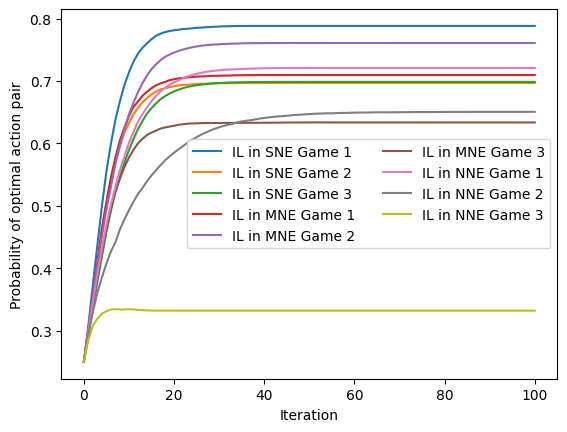

In [70]:
types_name = {"G1":"Game 1", "G2": "Game 2", "G3": "Game 3"}
for name, game in IL_test_games.items():
  for idx, reward in game.items():
    DCA_op_mean = np.mean(np.array(IL_op_trace[name][idx]), axis=0)
    plt.plot(range(len(DCA_op_mean)), DCA_op_mean, label='IL in ' +name + ' '+types_name[idx])

# for i,name in enumerate(IL_test_games):
#   IL_op_mean = np.mean(np.array(IL_op_trace[name]), axis=0)
#   plt.plot(range(len(IL_op_mean)), IL_op_mean, label='IL'+' in ' +types_name[name])

  # plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

plt.legend( ncol=2)

plt.savefig('comparison_random_expected.png', bbox_inches='tight')
# plt.show()



# Local Fairness Experiments

## Init & Final

In [ ]:
op_action_trace
local_fairness
r_local_fairness
global_fairness
agent1_reward
agent2_reward
designer_policy

agent1_single_reward
agent2_single_reward

agent1_policy
agent2_policy
designer_choice

first_action_pairs
agent1_policy_choice
agent2_policy_choice


test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]
# test_types = ["random"]


Filter Success

In [66]:
success_idx ={"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[]}
test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]
for name in test_types:
  success_idx[name] = [i for i,subtrace in enumerate(op_action_trace[name]) if subtrace[-1]>=0.99]

In [93]:
r_local_fairness_success = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[]}
test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]

for name in test_types:
  r_local_fairness_success[name] = [r_local_fairness[name][idx] for idx in success_idx[name]]

In [187]:
print(len(r_local_fairness_success['reward_related_local_fair']))

2102


Mean local fairness

In [90]:
local_fairness_mean = np.mean(np.array(r_local_fairness_success['local_fair']), axis=0)
# print(local_fairness_mean)
np.insert(local_fairness_mean, 0, 0.46)
extended_list = [element for element in local_fairness_mean for _ in range(7)][:100]
print(local_fairness_mean[0])

0.6741990753898744


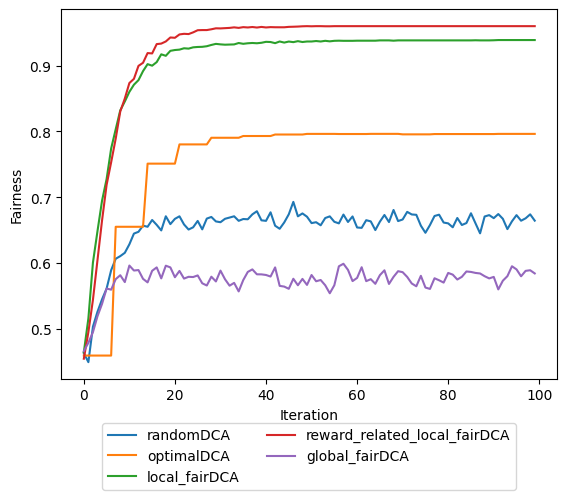

In [94]:
for name in test_types:
  local_fairness_mean = np.mean(np.array(r_local_fairness_success[name]), axis=0)
  if name == 'optimal':
    local_fairness_mean = np.insert(local_fairness_mean, 0, 0.46)
    local_fairness_mean = [element for element in local_fairness_mean for _ in range(7)][:100]

  plt.plot(range(len(local_fairness_mean)), local_fairness_mean, label=name+"DCA")

plt.xlabel('Iteration')
plt.ylabel('Fairness')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.savefig('r_local_fairness.png', bbox_inches='tight')
# plt.show()

Max Local fairness

In [77]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
ma = np.amax(a, axis= 0)
print(ma)

[ 9 10 11 12]


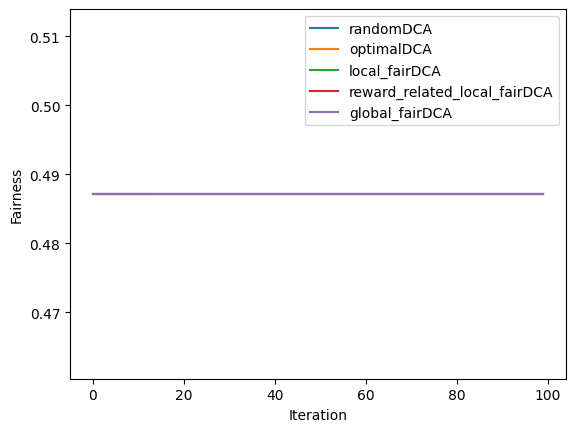

In [84]:
for name in test_types:
  local_fairness_mean_max = np.max(np.array(r_local_fairness_success[name]), axis=0)

  plt.plot(range(len(local_fairness_mean_max)), local_fairness_mean_max, label=name+"DCA")

plt.xlabel('Iteration')
plt.ylabel('Fairness')

plt.legend()

# plt.savefig('Single_NE_lf.png', bbox_inches='tight')
plt.show()

Min Local fairness

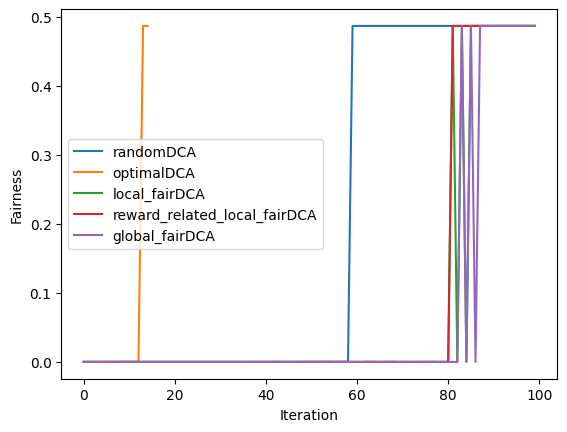

In [86]:
for name in test_types:
  local_fairness_mean_max = np.min(np.array(r_local_fairness_success[name]), axis=0)

  plt.plot(range(len(local_fairness_mean_max)), local_fairness_mean_max, label=name+"DCA")

plt.xlabel('Iteration')
plt.ylabel('Fairness')

plt.legend()

# plt.savefig('Single_NE_lf.png', bbox_inches='tight')
plt.show()

[0.8660254037844386, 0.9682458365518543, 0.9682458365518543, 0.9682458365518543, 0.9682458365518543, 1.0, 0.8660254037844386, 0.8660254037844386, 0.9682458365518543, 0.0, 0.9682458365518543, 0.9682458365518543, 1.0, 0.9682458365518543, 0.9682458365518543, 1.0, 0.8660254037844386, 0.9682458365518543, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.0, 0.8660254037844386, 0.0, 0.9682458365518543, 0.9682458365518543, 0.8660254037844386, 0.9682458365518543, 0.8660254037844386, 0.0, 0.8660254037844386, 1.0, 1.0, 0.0, 0.9682458365518543, 1.0, 0.8660254037844386, 0.8660254037844386, 1.0, 1.0, 0.9682458365518543, 0.9682458365518543, 1.0, 0.8660254037844386, 1.0, 0.9682458365518543, 0.0, 0.9682458365518543, 0.0, 0.0, 0.0, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.8660254037844386, 0.0, 0.0, 0.0, 0.9682458365518543, 0.9682458365518543, 0.0, 0.0, 0.9682458365518543, 0.8660254037844386, 0.8660254037844386, 0.0, 0.9682458365518543, 0.968245836551

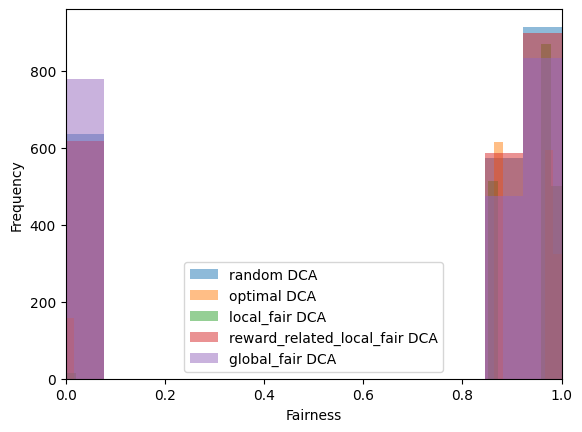

In [194]:
# np.mean(fairness_trace[-3:]) for fairness_trace in local_success_trace["optimal"]
# Example data
# local_consistent_success_trace = {"optimal": [], "local_fair": [], "global_fair":[]}
# test_types = ['local_fair', 'reward_related_local_fair', 'optimal', 'random']
for name in test_types:
  local_consistent_success_trace = [local_fairness[name][idx] for idx in success_idx[name]]
  # local_converge = [np.mean(trace[-3:]) for trace in local_consistent_success_trace]
  local_converge = [trace[-1] for trace in local_consistent_success_trace]
  print(local_converge)
  plt.hist(local_converge, bins='auto', alpha=0.5, label=name+' DCA')

# optimal_designer_local_fairness = [np.mean(fairness_trace[-3:]) for fairness_trace in local_success_trace["optimal"]]
# local_designer_local_fairness = np.random.normal(2, 0.5, 1000)
# global_designer_local_fairness = np.random.normal(-1, 2, 1000)

# # Creating the histogram for each distribution
# plt.hist(distribution1, bins='auto', alpha=0.5, label='Distribution 1')
# plt.hist(distribution2, bins='auto', alpha=0.5, label='Distribution 2')
# plt.hist(distribution3, bins='auto', alpha=0.5, label='Distribution 3')

# Setting labels and title
plt.xlabel('Fairness')
plt.ylabel('Frequency')
# plt.title('Multiple Distributions')

# Adding legend
plt.xlim(0, 1)
plt.legend()

# Display the plot
plt.show()


In [71]:
#agent1_reward = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}
#agent2_reward = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}
local_reward_difference = {"random":[], "optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}
local_success_reward_difference = {"random":[], "optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}

for name in test_types:
  local_reward_difference[name] = abs(np.array(agent1_single_reward[name])-np.array(agent2_single_reward[name]))
  local_success_reward_difference[name] = [local_reward_difference[name][idx] for idx in success_idx[name]]

In [72]:
local_success_first_reward_difference = {"random":[], "optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}
local_success_last_reward_difference = {"random":[], "optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}

for name in test_types:
  local_success_first_reward_difference[name] = np.array(local_success_reward_difference[name])[:,0]
  local_success_last_reward_difference[name] = np.array(local_success_reward_difference[name])[:,-1]

In [73]:
local_reward_difference_first = {"random":[], "optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}
local_reward_difference_final = {"random":[], "optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}
local_success_first_reward_difference = {"random":[], "optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}
local_success_last_reward_difference = {"random":[], "optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": []}


for name in test_types:
    r1 = agent1_single_reward[name]
    r2 = agent2_single_reward[name]
    local_reward_difference_first[name] = [abs(r1[i][0]-r2[i][0]) for i in range(len(r1))]
    local_reward_difference_final[name] = [abs(r1[i][-1]-r2[i][-1]) for i in range(len(r1))]
    local_success_first_reward_difference[name] = [local_reward_difference_first[name][idx] for idx in success_idx[name]]
    local_success_last_reward_difference[name] = [local_reward_difference_final[name][idx] for idx in success_idx[name]]

In [224]:
idx = 5
print(idx// 6)

0


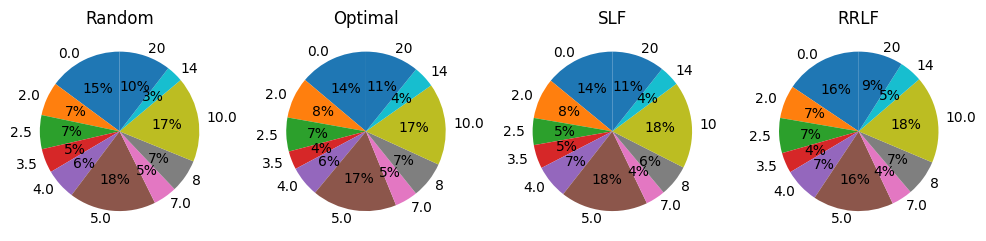

In [75]:
num_rows = 1
num_cols = 4
num_charts = 4

types_name = {"optimal":"Optimal", "local_fair": "SLF", "global_fair": "GF", "reward_related_local_fair":"RRLF", "random":"Random", "still":'Still'}
test_types = ['random', 'optimal','local_fair', 'reward_related_local_fair']

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for idx, name in enumerate(test_types):
    frequency_dict = Counter(local_success_first_reward_difference[name])
    frequency_dict = dict(sorted(frequency_dict.items()))

    values = list(frequency_dict.values())
    labels = frequency_dict.keys()

    # i = idx%num_cols
    # j = idx//num_cols

    axs[idx].pie(values, labels=labels,  autopct='%1.f%%', startangle=90)
    axs[idx].set_title(types_name[name])

plt.tight_layout()

# plt.show()
plt.savefig('init_reward_differece_lf.png', bbox_inches='tight')


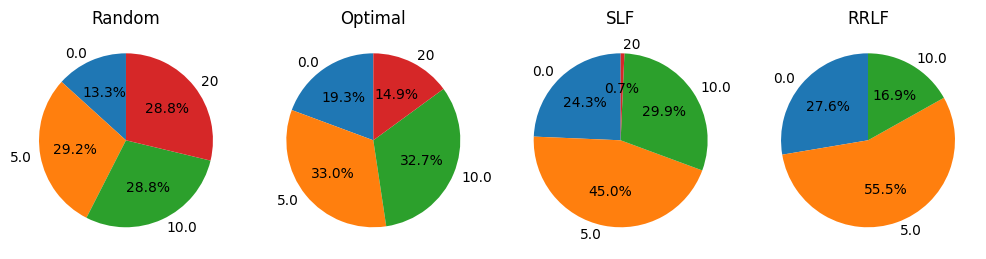

In [76]:
num_rows = 1
num_cols = 4
num_charts = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i, name in enumerate(test_types):
    frequency_dict = Counter(local_success_last_reward_difference[name])
    frequency_dict = dict(sorted(frequency_dict.items()))

    values = list(frequency_dict.values())
    labels = list(frequency_dict.keys())

    axs[i].pie(values, labels=labels,  autopct='%1.1f%%', startangle=90)
    axs[i].set_title(types_name[name])

plt.tight_layout()

# plt.show()
plt.savefig('final_reward_differece_lf.png', bbox_inches='tight')

## Recognizability

### Train

In [146]:
class Designer():
  def __init__(self, single_alloc, avail_alloc, n, recognizability=10, designer_type = "local_fair"):
    self.single_cell_alloc = np.array(single_alloc)
    self.avail_alloc = avail_alloc
    self.n = n
    self.r = recognizability
    # self.game_rewards = game_rewards
    self.designer_type = designer_type

    self.policy = [1/len(avail_alloc)] * len(avail_alloc)
    self.fairness_function = lambda v: pow(np.prod(v), 1/len(v)) # NSW
    self.exploration = 1

    self.local_fairness_trace = []
    self.r_local_fairness_trace = []
    self.global_fairness_trace = []
    self.policy_trace = [1/len(avail_alloc)]
    self.choice_trace = []

  def _calculate_normalised_local_fairness(self, alloc, credit, max_credit, lf_type = 'simple'):
    a, b = alloc, 1-alloc

    worst1 = min(min(self.single_cell_alloc), min(1-self.single_cell_alloc))
    worst2 = 1-worst1

    best_idx = np.argmin(abs(np.array(self.single_cell_alloc-0.5)))
    best1, best2 = self.single_cell_alloc[best_idx], 1-self.single_cell_alloc[best_idx]

    if lf_type == 'simple':
      return (pow(a*b, 1/2) - pow(worst1*worst2, 1/2))/(pow(best1*best2, 1/2) - pow(worst1*worst2, 1/2))
    elif lf_type == 'reward-related':
      return credit * pow(a*b, 1/2)/pow(best1*best2, 1/2)
    else:
      print('Undefined LF type')
      return

  def _calculate_normalised_global_fairness(self, accumulated_rewards, alloc, credit):
    a = self.single_cell_alloc
    r1, r2 = accumulated_rewards[0], accumulated_rewards[1]
    alloc1, alloc2 = alloc, 1-alloc
    gf = lambda x : pow((r1+credit*x)*(r2+credit*(1-x)), 1/2)

    current_f = pow((r1+credit*alloc1)*(r2+credit*alloc2), 1/2)
    min_f = 0
    max_f = 1
    if abs(r1-r2)<=credit:
      opt_a = (credit + r2 - r1) / (2*credit)
      # max_f = 0.5*(r1+r2+credit)

      best = min(a, key=lambda x: abs(x - opt_a))
      worst = max(a, key=lambda x: abs(x - opt_a))
    else:
      if r1>r2:
        best = min(a)
        worst = max(a)
      else:
        best = max(a)
        worst = min(a)

    min_f = gf(worst)
    max_f = gf(best)

    if min_f==max_f:
      return 0

    return (current_f - min_f)/(max_f - min_f)

  def _calculate_gf_for_plot(self, accumulated_rewards, alloc, credit):
    r1, r2 = accumulated_rewards[0], accumulated_rewards[1]
    alloc1, alloc2 = alloc, 1-alloc
    current_f = pow((r1+credit*alloc1)*(r2+credit*alloc2), 1/2)
    min_f = 0
    max_f = 1
    if abs(r1-r2)<=credit:
      max_f = 0.5*(r1+r2+credit)
      if r1>r2:
        min_f = pow((r1+credit)*r2, 1/2)
      else:
        min_f = pow((r2+credit)*r1, 1/2)
    else:
      if r1>r2:
        min_f = pow((r1+credit)*r2, 1/2)
        max_f = pow((r2+credit)*r1, 1/2)
      else:
        min_f = pow((r2+credit)*r1, 1/2)
        max_f = pow((r1+credit)*r2, 1/2)

    if min_f==max_f:
      return 0

    return (current_f - min_f)/(max_f - min_f)

  def update_policy(self, action, accumulated_rewards, credit, max_credit, normalized_credit, current_alloc_idx, current_step):
    self.choice_trace.append(current_alloc_idx)

    current_alloc1 = self.avail_alloc[current_alloc_idx][action[0]][action[1]]
    current_alloc2 = 1- current_alloc1

    # normalised local fairness for all allocations (range from 0 to 1) - for comparison
    normalized_local_fairness = 2*pow(current_alloc1*current_alloc2, 1/self.n)
    r_related_normalised_local_fairness = 2*credit*pow(current_alloc1*current_alloc2, 1/self.n)/max_credit

    self.local_fairness_trace.append(normalized_local_fairness)
    self.r_local_fairness_trace.append(r_related_normalised_local_fairness)

    # normalised local fairness for current allocation space - for updating policy
    normalized_local_fairness = self._calculate_normalised_local_fairness(current_alloc1, normalized_credit, max_credit)
    r_related_normalised_local_fairness = self._calculate_normalised_local_fairness(current_alloc1, normalized_credit, max_credit, 'reward-related')

    global_normalised_fairness = self._calculate_normalised_global_fairness(accumulated_rewards, current_alloc1, credit)
    self.exploration = 1-global_normalised_fairness
    # self.exploration = 1- pow(global_normalised_fairness, 7)

    self.global_fairness_trace.append(self._calculate_gf_for_plot(accumulated_rewards, current_alloc1, credit))

    # Designer varies, reward varies
    reward = 0
    if self.designer_type == "local_fair":
      reward = pow(normalized_local_fairness, self.r)

    elif self.designer_type == "reward_related_local_fair":
      reward = pow(r_related_normalised_local_fairness, self.r)

    elif self.designer_type == "global_fair":
      reward = global_normalised_fairness
      # reward = pow(global_normalised_fairness, 7)

    elif self.designer_type == "optimal":
      reward = pow(normalized_credit, self.r)
      # reward = self._calculate_optimal_reward(normalized_credit)

    elif self.designer_type == "random":
      return
    elif self.designer_type == "still":
      reward = 1
    else:
      print("Designer",self.designer_type, "does not exist.")
      return

    # update policy
    for i in range(len(self.avail_alloc)):
      if i == current_alloc_idx:
        self.policy[i] += reward - self.policy[i]*reward
      else:
        self.policy[i] += -self.policy[i]*reward

    self.policy_trace.append(max(self.policy))

  def take_action(self):
    explore = random.uniform(0, 1)
    p = self.policy

    if self.designer_type == "global_fair" and explore < self.exploration:
      p = [1/len(self.avail_alloc)] * len(self.avail_alloc)

    index, selected = random.choices(list(enumerate(self.avail_alloc)), p)[0]
    return selected, index

In [ ]:
# class Designer():
#   def __init__(self, single_alloc, avail_alloc, n, recognizability=10, designer_type = "local_fair"):
#     self.single_cell_alloc = np.array(single_alloc)
#     self.avail_alloc = avail_alloc
#     self.n = n
#     self.r = recognizability
#     # self.game_rewards = game_rewards
#     self.designer_type = designer_type

#     self.policy = [1/len(avail_alloc)] * len(avail_alloc)
#     self.fairness_function = lambda v: pow(np.prod(v), 1/len(v)) # NSW
#     self.exploration = 1

#     self.local_fairness_trace = []
#     self.r_local_fairness_trace = []
#     self.global_fairness_trace = []
#     self.policy_trace = [1/len(avail_alloc)]
#     self.choice_trace = []

#   def _calculate_normalised_local_fairness(self, alloc, credit, max_credit, lf_type = 'simple'):
#     a, b = alloc, 1-alloc

#     worst1 = min(min(self.single_cell_alloc), min(1-self.single_cell_alloc))
#     worst2 = 1-worst1

#     best_idx = np.argmin(abs(np.array(self.single_cell_alloc-0.5)))
#     best1, best2 = self.single_cell_alloc[best_idx], 1-self.single_cell_alloc[best_idx]

#     if lf_type == 'simple':
#       return (pow(a*b, 1/2) - pow(worst1*worst2, 1/2))/(pow(best1*best2, 1/2) - pow(worst1*worst2, 1/2))
#     elif lf_type == 'reward-related':
#       return credit * pow(a*b, 1/2)/pow(best1*best2, 1/2)
#     else:
#       print('Undefined LF type')
#       return

#   def _calculate_normalised_global_fairness(self, accumulated_rewards, alloc, credit):
#     r1, r2 = accumulated_rewards[0], accumulated_rewards[1]
#     alloc1, alloc2 = alloc, 1-alloc
#     current_f = pow((r1+credit*alloc1)*(r2+credit*alloc2), 1/2)
#     min_f = 0
#     max_f = 1
#     if abs(r1-r2)<=credit:
#       max_f = 0.5*(r1+r2+credit)
#       if r1>r2:
#         min_f = pow((r1+credit)*r2, 1/2)
#       else:
#         min_f = pow((r2+credit)*r1, 1/2)
#     else:
#       if r1>r2:
#         min_f = pow((r1+credit)*r2, 1/2)
#         max_f = pow((r2+credit)*r1, 1/2)
#       else:
#         min_f = pow((r2+credit)*r1, 1/2)
#         max_f = pow((r1+credit)*r2, 1/2)

#     if min_f==max_f:
#       return 0

#     return (current_f - min_f)/(max_f - min_f)

#   def _calculate_optimal_reward(self, normalized_credit):
#     if normalized_credit == 1:
#       return 1
#     else:
#       return 0

#   def update_policy(self, action, accumulated_rewards, credit, max_credit, normalized_credit, current_alloc_idx, current_step):
#     self.choice_trace.append(current_alloc_idx)

#     current_alloc1 = self.avail_alloc[current_alloc_idx][action[0]][action[1]]
#     current_alloc2 = 1- current_alloc1

#     # normalised local fairness for all allocations (range from 0 to 1) - for comparison
#     normalized_local_fairness = 2*pow(current_alloc1*current_alloc2, 1/self.n)
#     r_related_normalised_local_fairness = 2*credit*pow(current_alloc1*current_alloc2, 1/self.n)/max_credit

#     self.local_fairness_trace.append(normalized_local_fairness)
#     self.r_local_fairness_trace.append(r_related_normalised_local_fairness)

#     # normalised local fairness for current allocation space - for updating policy
#     normalized_local_fairness = self._calculate_normalised_local_fairness(current_alloc1, normalized_credit, max_credit)
#     r_related_normalised_local_fairness = self._calculate_normalised_local_fairness(current_alloc1, normalized_credit, max_credit, 'reward-related')

#     global_normalised_fairness = self._calculate_normalised_global_fairness(accumulated_rewards, current_alloc1, credit)
#     self.exploration = 1-global_normalised_fairness

#     self.global_fairness_trace.append(global_normalised_fairness)

#     # Designer varies, reward varies
#     reward = 0
#     if self.designer_type == "local_fair":
#       reward = pow(normalized_local_fairness, self.r)

#     elif self.designer_type == "reward_related_local_fair":
#       reward = pow(r_related_normalised_local_fairness, self.r)

#     elif self.designer_type == "global_fair":
#       reward = global_normalised_fairness

#     elif self.designer_type == "optimal":
#       # reward = normalized_credit
#       reward = self._calculate_optimal_reward(normalized_credit)

#     elif self.designer_type == "random":
#       return
#     elif self.designer_type == "still":
#       reward = 1
#     else:
#       print("Designer",self.designer_type, "does not exist.")
#       return

#     # update policy
#     for i in range(len(self.avail_alloc)):
#       if i == current_alloc_idx:
#         self.policy[i] += reward - self.policy[i]*reward
#       else:
#         self.policy[i] += -self.policy[i]*reward

#     self.policy_trace.append(max(self.policy))

#   def take_action(self):
#     explore = random.randrange(0,1)
#     p = self.policy

#     if self.designer_type == "global_fair" and explore < self.exploration:
#       p = [1/len(self.avail_alloc)] * len(self.avail_alloc)

#     index, selected = random.choices(list(enumerate(self.avail_alloc)), p)[0]
#     return selected, index

In [147]:
def train_DCA_r(game_rewards, test_types, r_list, total_game_num = 1000, iter_num = 100):
    for designer_type in test_types:
      for r in r_list:
        test_game = Game(game_rewards)
        print(designer_type)
        print(r)
        for i in range(total_game_num):
          test_designer = Designer(single_alloc[designer_type], full_alloc[designer_type], 2, r, designer_type)
          test_agent1 = Agent(agent1_action)
          test_agent2 = Agent(agent2_action)

          test = Cross_Learning_Playground(test_designer, [test_agent1, test_agent2], test_game, iter_num)
          test.train()

          p1a1 = np.array(test.agents[0].policy_trace[0])
          p2a1 = np.array(test.agents[1].policy_trace[0])
          op_action = p1a1*p2a1
          op_action_trace[designer_type][r].append(op_action)

          agent1_policy[designer_type][r].append(test.agents[0].policy_trace)
          agent2_policy[designer_type][r].append(test.agents[1].policy_trace)
          designer_choice[designer_type][r].append(test.designer.choice_trace)

          local_fairness[designer_type][r].append(test.designer.local_fairness_trace)
          r_local_fairness[designer_type][r].append(test.designer.r_local_fairness_trace)
          global_fairness[designer_type][r].append(test.designer.global_fairness_trace)

          agent1_reward[designer_type][r].append(test.agents[0].reward_trace)
          agent2_reward[designer_type][r].append(test.agents[1].reward_trace)
          designer_policy[designer_type][r].append(test.designer.policy_trace)

          agent1_single_reward[designer_type][r].append(test.agents[0].single_reward_trace)
          agent2_single_reward[designer_type][r].append(test.agents[1].single_reward_trace)

          first_action_pairs[designer_type][r].append(test.first_actions)
          agent1_policy_choice[designer_type][r].append(test.agents[0].policy_choice_trace)
          agent2_policy_choice[designer_type][r].append(test.agents[1].policy_choice_trace)

In [149]:
op_action_trace = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
local_fairness = {'optimal':{1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
r_local_fairness = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair':{1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair':{1:[], 3: [], 5: [], 7:[], 10:[]}}
global_fairness = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair':{1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
agent1_reward = {'optimal':{1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair':{1:[], 3: [], 5: [], 7:[], 10:[]}}

agent2_reward = {'optimal':{1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
designer_policy = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair':{1:[], 3: [], 5: [], 7:[], 10:[]}}

agent1_single_reward = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
agent2_single_reward = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}


agent1_policy = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
agent2_policy = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair':{1:[], 3: [], 5: [], 7:[], 10:[]} }
designer_choice = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]} }


first_action_pairs = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]} }
agent1_policy_choice = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
agent2_policy_choice = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}

test_types = ['optimal', "local_fair", 'reward_related_local_fair']
# r_test = [1,10,20,30,50,100]
r_test = [1,3,5,7,10]

# test_types = ["random"]
train_DCA_r(game_rewards1, test_types, r_test, 1000, 100)

optimal
1
optimal
3
optimal
5
optimal
7
optimal
10
local_fair
1
local_fair
3
local_fair
5
local_fair
7
local_fair
10
reward_related_local_fair
1
reward_related_local_fair
3
reward_related_local_fair
5
reward_related_local_fair
7
reward_related_local_fair
10


In [151]:
print(len(success_idx['local_fair'][1]))

0


### Data process

Filter

In [152]:
success_idx ={'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
# test_types = ["local_fair"]
r_test = [1,3,5,7,10]

for name in test_types:
  for r in r_test:
    success_idx[name][r] = [i for i,subtrace in enumerate(op_action_trace[name][r]) if subtrace[-1]>=0.99]

Reward difference

In [116]:
a = [[1,2,3,4,5], [6,5,4,3,2]]

b = [abs(sub[0]-sub[1]) for sub in a]
print(b)

[1, 1]


In [153]:
# local_reward_difference_first = {'local_fair': {"5":[], "10": [], "20": [], "30":[], "50":[], "100":[]},
#                                 'reward_related_local_fair': {"5":[], "10": [], "20": [], "30":[], "50":[], "100":[]}}
local_reward_difference_final = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}
# local_success_first_reward_difference = {'local_fair': {"5":[], "10": [], "20": [], "30":[], "50":[], "100":[]},
#                                           'reward_related_local_fair': {"5":[], "10": [], "20": [], "30":[], "50":[], "100":[]}}
local_success_last_reward_difference = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}


for name in test_types:
  for r in r_test:
    r1 = agent1_single_reward[name][r]
    r2 = agent2_single_reward[name][r]
    # local_reward_difference_first[name][r] = [abs(r1[i][0]-r2[i][0]) for i in range(len(r1))]
    local_reward_difference_final[name][r] = [abs(r1[i][-1]-r2[i][-1]) for i in range(len(r1))]
    # local_success_first_reward_difference[name] = [local_reward_difference_first[name][r][idx] for idx in success_idx[name][r]]
    local_success_last_reward_difference[name][r] = [local_reward_difference_final[name][r][idx] for idx in success_idx[name][r]]

[0.0, 5.0, 5.0, 5.0, 5.0, 10.0, 5.0, 10.0, 5.0, 5.0, 10.0, 5.0, 5.0, 5.0, 10.0, 0.0, 0.0, 5.0, 10.0, 5.0, 5.0, 10.0, 5.0, 5.0, 0.0, 5.0, 5.0, 0.0, 10.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 0.0, 5.0, 5.0, 10.0, 5.0, 5.0, 0.0, 5.0, 10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 5.0, 5.0, 5.0, 0.0, 10.0, 10.0, 10.0, 5.0, 5.0, 10.0, 10.0, 5.0, 0.0, 5.0, 5.0, 5.0, 0.0, 5.0, 0.0, 10.0, 10.0, 5.0, 0.0, 0.0, 10.0, 5.0, 10.0, 5.0, 5.0, 5.0, 5.0, 10.0, 10.0, 10.0, 10.0, 10.0, 0.0, 5.0, 0.0, 5.0, 5.0, 5.0, 10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 0.0, 10.0, 5.0, 5.0, 5.0, 10.0, 10.0, 0.0, 5.0, 10.0, 5.0, 10.0, 5.0, 5.0, 10.0, 5.0, 10.0, 10.0, 10.0, 0.0, 0.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 5.0, 10.0, 5.0, 0.0, 10.0, 5.0, 5.0, 0.0, 0.0, 5.0, 0.0, 10.0, 10.0, 10.0, 5.0, 10.0, 10.0, 0.0, 5.0, 0.0, 5.0, 10.0, 10.0, 5.0, 5.0, 10.0, 5.0, 5.0, 10.0, 5.0, 0.0, 5.0, 10.0, 5.0, 5.0, 5.0, 0.0, 5.0, 0.0, 10.0, 5.0, 5.0, 5.0, 5.0, 10.0, 10.0, 5.0, 0.0, 10.0, 0.0, 5.0, 5.0, 5.0, 5.0, 10.0, 10.0, 5.0, 5.0, 0.0, 10.

Count

In [155]:
# First

reward_difference_stats = {'optimal': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]},
                   'reward_related_local_fair': {1:[], 3: [], 5: [], 7:[], 10:[]}}

a = {'optimal': {}, 'local_fair': {}, 'reward_related_local_fair': {}}
for name in test_types:
  for i, r in enumerate(r_test):
    len_r = len(local_success_last_reward_difference[name][r])
    frequency_dict = Counter(local_success_last_reward_difference[name][r])
    frequency_dict = dict(sorted(frequency_dict.items()))

    reward_difference_stats[name][r] = frequency_dict

    values = list(frequency_dict.values())
    labels = frequency_dict.keys()

    for label in labels:
      if label in a[name]:
        a[name][label].append(frequency_dict[label]/len_r)
      else:
        a[name][label] = [frequency_dict[label]/len_r]

    for (key,sub) in a[name].items():
      if len(sub)<i+1:
        a[name][key].append(0)

In [156]:
print(a)

{'optimal': {0.0: [0.21664275466284075, 0.18962962962962962, 0.2276536312849162, 0.2059238363892807, 0.20473537604456823], 5.0: [0.3988522238163558, 0.41333333333333333, 0.4036312849162011, 0.4076163610719323, 0.3983286908077994], 10.0: [0.38450502152080346, 0.397037037037037, 0.3687150837988827, 0.38645980253878703, 0.3969359331476323]}, 'local_fair': {0.0: [0.30513176144244103, 0.3926470588235294, 0.5158045977011494, 0.5590327169274538, 0.6814921090387375], 5.0: [0.5048543689320388, 0.46176470588235297, 0.3290229885057471, 0.27453769559032715, 0.15351506456241032], 10.0: [0.1900138696255201, 0.14558823529411766, 0.15517241379310345, 0.16642958748221906, 0.1649928263988522]}, 'reward_related_local_fair': {0.0: [0.21923620933521923, 0.24822695035460993, 0.2489208633093525, 0.3062409288824383, 0.3701578192252511], 5.0: [0.42715700141442714, 0.4808510638297872, 0.5323741007194245, 0.5602322206095791, 0.5882352941176471], 10.0: [0.3536067892503536, 0.27092198581560284, 0.218705035971223, 

### plot

local_fair

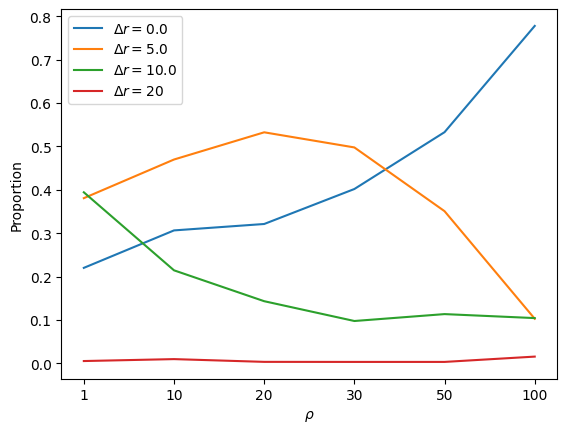

In [120]:
lf_reward_difference_stats = a['local_fair']

for key,sub in lf_reward_difference_stats.items():
  plt.plot(range(len(r_test)), sub, label=r'$\Delta r = $'+ str(key))

plt.xticks(range(len(r_test)), r_test)

plt.xlabel(r'$\rho$')
plt.ylabel('Proportion')

plt.legend()

plt.savefig('SLF_local_fairness_different_r.png', bbox_inches='tight')

# plt.show()

In [142]:
a['reward_related_local_fair'][20] = [0,0,0,0,0,0]
rrlf_reward_difference_stats = a['reward_related_local_fair']

for key,sub in rrlf_reward_difference_stats.items():
  plt.plot(range(len(r_test)), sub, label=r'$\Delta r = $'+ str(key))

# plt.plot(range(len(r_test)), rrlf_reward_difference_stats[0], label=0)
# plt.plot(range(len(r_test)), rrlf_reward_difference_stats[5], label=5)
# plt.plot(range(len(r_test)), rrlf_reward_difference_stats[10], label=10)
# plt.plot(range(len(r_test)), rrlf_reward_difference_stats[20], label=20)
  # for i, value in enumerate(sub):
  #     plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(range(len(r_test)), r_test)

plt.xlabel(r'$\rho$')
plt.ylabel('Proportion')

plt.legend()

plt.savefig('RRLF_local_fairness_different_r.png', bbox_inches='tight')

# plt.show()

TypeError: ignored

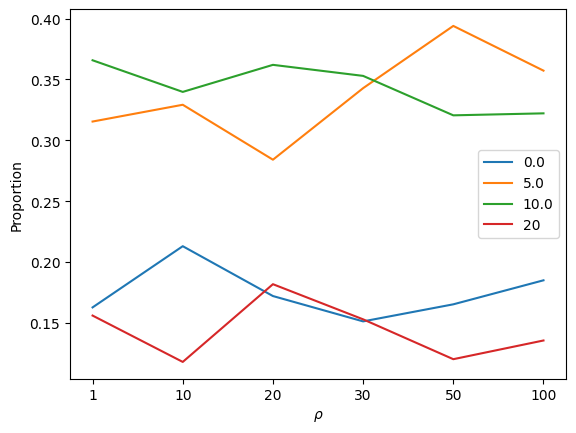

In [122]:
# a['reward_related_local_fair'][20] = [0,0,0,0,0,0]
rrlf_reward_difference_stats = a['optimal']

for key,sub in rrlf_reward_difference_stats.items():
  plt.plot(range(len(r_test)), sub, label=r'$\Delta r = $'+ str(key))

# plt.plot(range(len(r_test)), rrlf_reward_difference_stats[0], label=0)
# plt.plot(range(len(r_test)), rrlf_reward_difference_stats[5], label=5)
# plt.plot(range(len(r_test)), rrlf_reward_difference_stats[10], label=10)
# plt.plot(range(len(r_test)), rrlf_reward_difference_stats[20], label=20)
  # for i, value in enumerate(sub):
  #     plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(range(len(r_test)), r_test)

plt.xlabel(r'$\rho$')
plt.ylabel('Proportion')

plt.legend()

plt.savefig('optimal_local_fairness_different_r.png', bbox_inches='tight')

# plt.show()

### Exp 4 continue - DDP with recognizability

Failed

In [194]:
converge_types = ["optimal","local_fair", "reward_related_local_fair"]
name = 'reward_related_local_fair'

test_r = [1,3,5,7,10]
fail_idx = {1:[], 3: [], 5: [], 7:[], 10:[]}

designer_choice_fail = {1:[], 3: [], 5: [], 7:[], 10:[]}
agent1_policy_fail = {1:[], 3: [], 5: [], 7:[], 10:[]}
agent2_policy_fail = {1:[], 3: [], 5: [], 7:[], 10:[]}

for r in test_r:
  fail_idx[r] = [i for i,subtrace in enumerate(op_action_trace[name][r]) if subtrace[-1]<0.99]
  designer_choice_fail[r] = [designer_choice[name][r][i] for i in fail_idx[r]]
  agent1_policy_fail[r] = [agent1_policy[name][r][i] for i in fail_idx[r]]
  agent2_policy_fail[r] = [agent2_policy[name][r][i] for i in fail_idx[r]]



Converge speed in DCAs

In [195]:
# opt_designer_choice = designer_choice['optimal']
designer_converge_iter = {1:[], 3: [], 5: [], 7:[], 10:[]}
# test_types = ["optimal","local_fair", "reward_related_local_fair"]
# name = ['optimal']

# test_r = [1,10,20,30,50,100]

for r in test_r:
  for trace in designer_choice_fail[r]:
    a = np.where(np.diff(np.array(trace)[::-1]) != 0)

    if len(a[0]) == 0:
      a = len(trace)-1
    else:
      a = a[0][0]

    choice_converge_index = len(trace) - a
    if name == 'optimal':
      choice_converge_index = 1+(choice_converge_index-1)*OPTIMAL_INTERNEL_SIZE
    designer_converge_iter[r].append(choice_converge_index)

In [196]:
# opt_designer_choice = designer_choice['optimal']
agent1_converge_iter = {1:[], 3: [], 5: [], 7:[], 10:[]}
agent2_converge_iter = {1:[], 3: [], 5: [], 7:[], 10:[]}

# test_types = ["optimal","local_fair", "reward_related_local_fair"]

for r in test_r:
  for i in range(len(agent1_policy_fail[r])):
    a1_p0 = np.array(agent1_policy_fail[r][i][0])
    a2_p0 = np.array(agent2_policy_fail[r][i][0])
    idx1 = 0
    idx2 = 0

    if a1_p0[-1] > 0.99:
      idx1 = np.where(a1_p0 > 0.99)[0][0]
    elif a1_p0[-1] <0.01:
      idx1 = np.where(a1_p0 < 0.01)[0][0]
    else:
      idx1 = np.where(np.diff(a1_p0[::-1]) != 0)[0][-1]+1

    if a2_p0[-1] > 0.99:
      idx2 = np.where(a2_p0 > 0.99)[0][0]
    elif a2_p0[-1] <0.01:
      idx2 = np.where(a2_p0 < 0.01)[0][0]
    else:
      idx2 = np.where(np.diff(a2_p0[::-1]) != 0)[0][-1]+1

    agent1_converge_iter[r].append(idx1)
    agent2_converge_iter[r].append(idx2)

In [197]:
convergence_order = {1:[0,0,0], 3: [0,0,0], 5: [0,0,0], 7:[0,0,0], 10:[0,0,0]}

# converge_types = ["optimal","local_fair", "reward_related_local_fair"]
for r in test_r:
  for i in range(len(designer_converge_iter[r])):
    d, p1, p2 = designer_converge_iter[r][i], agent1_converge_iter[r][i], agent2_converge_iter[r][i]

    # print(name)
    # print(i, d, p1, p2)
    if d <= p1 and d<= p2:
      convergence_order[r][0]+=1
    elif (d>p1 and d <= p2) or (d>p2 and d <= p1):
      convergence_order[r][1]+=1
    elif d>p1 and d > p2:
      convergence_order[r][2]+=1
    else:
      print('??', name, i, d, p1, p2)
      break
    # break

In [198]:
print(convergence_order)

# optimal: {1: [134, 39, 110], 3: [4, 0, 321], 5: [1, 0, 283], 7: [0, 0, 291], 10: [1, 0, 306], 20: [3, 0, 295], 30: [3, 0, 316], 50: [3, 0, 298], 100: [2, 0, 286]}
# local_fair: {1: [305, 2, 1], 10: [287, 7, 9], 20: [285, 2, 9], 30: [267, 6, 4], 50: [297, 0, 1], 100: [275, 4, 2]}
# rrlf: {1: [265, 14, 2], 3: [11, 3, 281], 5: [4, 0, 301], 7: [7, 1, 303], 10: [3, 0, 300], 20: [6, 0, 291], 30: [7, 0, 293], 50: [8, 0, 272], 100: [10, 0, 278]}


{1: [270, 19, 4], 3: [11, 3, 281], 5: [4, 0, 301], 7: [7, 1, 303], 10: [3, 0, 300]}


Full

Converge speed in DCAs

In [199]:
# opt_designer_choice = designer_choice['optimal']
designer_converge_iter = {1:[], 3: [], 5: [], 7:[], 10:[]}

# test_types = ["optimal","local_fair", "reward_related_local_fair"]
# name = ['optimal']

# test_r = [1,10,20,30,50,100]

for r in test_r:
  for trace in designer_choice[name][r]:
    a = np.where(np.diff(np.array(trace)[::-1]) != 0)

    if len(a[0]) == 0:
      a = len(trace)-1
    else:
      a = a[0][0]

    choice_converge_index = len(trace) - a
    if name == 'optimal':
      choice_converge_index = 1+(choice_converge_index-1)*OPTIMAL_INTERNEL_SIZE
    designer_converge_iter[r].append(choice_converge_index)

In [200]:
# opt_designer_choice = designer_choice['optimal']
agent1_converge_iter = {1:[], 3: [], 5: [], 7:[], 10:[]}
agent2_converge_iter = {1:[], 3: [], 5: [], 7:[], 10:[]}
# test_types = ["optimal","local_fair", "reward_related_local_fair"]

for r in test_r:
  for i in range(len(agent1_policy[name][r])):
    a1_p0 = np.array(agent1_policy[name][r][i][0])
    a2_p0 = np.array(agent2_policy[name][r][i][0])
    idx1 = 0
    idx2 = 0

    if a1_p0[-1] > 0.99:
      idx1 = np.where(a1_p0 > 0.99)[0][0]
    elif a1_p0[-1] <0.01:
      idx1 = np.where(a1_p0 < 0.01)[0][0]
    else:
      idx1 = np.where(np.diff(a1_p0[::-1]) != 0)[0][-1]+1

    if a2_p0[-1] > 0.99:
      idx2 = np.where(a2_p0 > 0.99)[0][0]
    elif a2_p0[-1] <0.01:
      idx2 = np.where(a2_p0 < 0.01)[0][0]
    else:
      idx2 = np.where(np.diff(a2_p0[::-1]) != 0)[0][-1]+1

    agent1_converge_iter[r].append(idx1)
    agent2_converge_iter[r].append(idx2)

In [201]:
convergence_order = {1:[0,0,0], 3: [0,0,0], 5: [0,0,0], 7:[0,0,0], 10:[0,0,0]}

# converge_types = ["optimal","local_fair", "reward_related_local_fair"]
for r in test_r:
  for i in range(len(designer_converge_iter[r])):
    d, p1, p2 = designer_converge_iter[r][i], agent1_converge_iter[r][i], agent2_converge_iter[r][i]

    # print(name)
    # print(i, d, p1, p2)
    if d <= p1 and d<= p2:
      convergence_order[r][0]+=1
    elif (d>p1 and d <= p2) or (d>p2 and d <= p1):
      convergence_order[r][1]+=1
    elif d>p1 and d > p2:
      convergence_order[r][2]+=1
    else:
      print('??', name, i, d, p1, p2)
      break
    # break

In [202]:
print(convergence_order)

# optimal
#  {1: [814, 76, 110], 3: [633, 46, 321], 5: [669, 46, 285], 7: [664, 44, 292],
# 10: [652, 41, 307],
# 20: [665, 40, 295],
# 30: [650, 33, 317],
# 50: [665, 36, 299],
# 100: [663, 50, 287]}

# optimal: {1: [134, 39, 110], 3: [4, 0, 321], 5: [1, 0, 283], 7: [0, 0, 291],
# 10: [1, 0, 306], 20: [3, 0, 295], 30: [3, 0, 316], 50: [3, 0, 298], 100: [2, 0, 286]}



# local_fair
# {1: [953, 23, 24], 10: [849, 51, 100], 20: [869, 40, 91], 30: [879, 45, 76], 50: [860, 52, 88], 100: [862, 58, 80]}

# rrlf: {1: [984, 14, 2], 3: [702, 17, 281], 5: [638, 54, 308], 7: [581, 98, 321], 10: [587, 87, 326], 20: [569, 101, 330], 30: [471, 94, 435], 50: [398, 84, 518], 100: [467, 106, 427]}
# rrlf: {1: [265, 14, 2], 3: [11, 3, 281], 5: [4, 0, 301], 7: [7, 1, 303], 10: [3, 0, 300], 20: [6, 0, 291], 30: [7, 0, 293], 50: [8, 0, 272], 100: [10, 0, 278]}


{1: [977, 19, 4], 3: [702, 17, 281], 5: [638, 54, 308], 7: [581, 98, 321], 10: [587, 87, 326]}


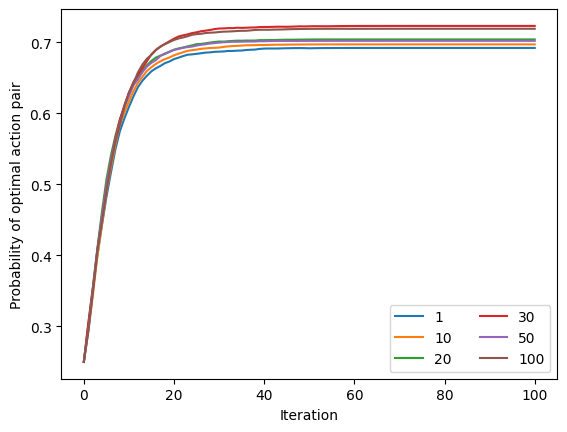

In [110]:
# types_name = {"optimal":"Optimal", "local_fair": "SLF", "global_fair": "GF", "reward_related_local_fair":"RRLF", "random":"Random", "still":'Still'}
# test_types = ["optimal","local_fair", "reward_related_local_fair", 'global_fair']
# mean_value = {'JAL' : 0, 'SNE': 0, 'MNE': 0, 'NNE': 0, "random": 0, "optimal": 0,"local_fair": 0, "reward_related_local_fair": 0, "global_fair": 0}

name = 'local_fair'
for r in r_test:
  DCA_op_mean = np.mean(np.array(op_action_trace[name][r]), axis=0)
  # mean_value[name] = DCA_op_mean[-1]
  plt.plot(range(len(DCA_op_mean)), DCA_op_mean, label=r)


# plt.plot(range(len(JA_op_mean)), JA_op_mean, label="JAL")
# mean_value['JAL'] = JA_op_mean[-1]

# for name in IL_test_games:
#   IL_op_mean = np.mean(np.array(IL_op_trace[name]), axis=0)
#   mean_value[name] = IL_op_mean[-1]
#   plt.plot(range(len(IL_op_mean)), IL_op_mean, label='IL with '+name)

  # plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel('Iteration')
plt.ylabel('Probability of optimal action pair')

plt.legend(ncol=2)

# plt.savefig('Comparison_all_g1.png', bbox_inches='tight')
plt.show()

In [ ]:
#  {1: [814, 76, 110], 3: [633, 46, 321], 5: [669, 46, 285], 7: [664, 44, 292],
# 10: [652, 41, 307],
# 20: [665, 40, 295],
# 30: [650, 33, 317],
# 50: [665, 36, 299],
# 100: [663, 50, 287]}

# rrlf: {1: [984, 14, 2], 3: [702, 17, 281], 5: [638, 54, 308], 7: [581, 98, 321],
# 10: [609, 74, 317], 20: [569, 101, 330], 30: [471, 94, 435], 50: [398, 84, 518], 100: [467, 106, 507]}


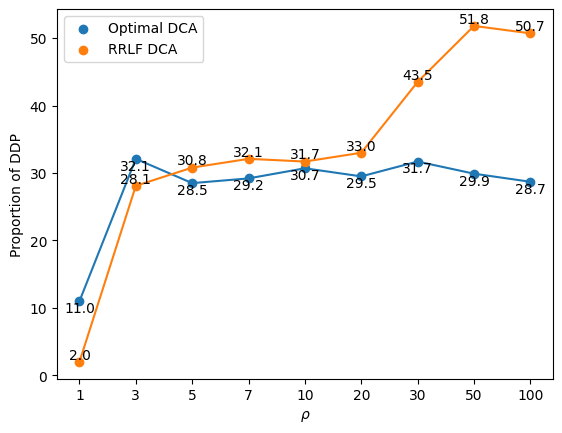

In [193]:
# types_name = {"optimal":"Optimal", "local_fair": "SLF", "global_fair": "GF", "reward_related_local_fair":"RRLF", "random":"Random", "still":'Still'}
test_types = ["optimal","reward_related_local_fair"]
# mean_value = {'JAL' : 0, 'SNE': 0, 'MNE': 0, 'NNE': 0, "random": 0, "optimal": 0,"local_fair": 0, "reward_related_local_fair": 0, "global_fair": 0}

ppd_proportion = {'optimal':[11.0, 32.1, 28.5, 29.2, 30.7, 29.5, 31.7, 29.9, 28.7],
                  'reward_related_local_fair':[2.0, 28.1, 30.8, 32.1, 31.7, 33.0, 43.5, 51.8, 50.7]}

keys = ['1', '3', '5', '7', '10', '20', '30', '50', '100']
# name = 'local_fair'
# for name in test_types:
  # DCA_op_mean = np.mean(np.array(op_action_trace[name][r]), axis=0)
  # # mean_value[name] = DCA_op_mean[-1]
plt.scatter(keys, ppd_proportion["optimal"], label=types_name["optimal"]+' DCA')

for key, value in zip(keys, ppd_proportion["optimal"]):
  plt.text(key, value, f'{value:.1f}', ha='center', va='top')

plt.plot(keys, ppd_proportion["optimal"], linestyle='-', marker='', markersize=2)


plt.scatter(keys, ppd_proportion["reward_related_local_fair"], label=types_name["reward_related_local_fair"]+' DCA')

for key, value in zip(keys, ppd_proportion["reward_related_local_fair"]):
  plt.text(key, value, f'{value:.1f}', ha='center', va='bottom')

plt.plot(keys, ppd_proportion["reward_related_local_fair"], linestyle='-', marker='', markersize=2)

# keys = ['1', '3', '5', '7', '10', '20', '30', '50', '100']
# # values = list(mean_value.values())

# # Create a bar plot
# plt.figure(figsize=(10, 6))  # Optional: Set the figure size
# # bars = plt.bar(keys, values, color='royalblue')
# plt.scatter(keys, values, color='royalblue')

# # Add labels for each bar
# # for bar, value in zip(bars, values):
# #     plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.4f}', ha='center', va='bottom')
# for key, value in zip(keys, values):
#     plt.text(key, value, f'{value:.4f}', ha='center', va='bottom')

# plt.plot(keys, values, linestyle='-', color='gray', marker='', markersize=2)

# plt.plot(range(len(JA_op_mean)), JA_op_mean, label="JAL")
# mean_value['JAL'] = JA_op_mean[-1]

# for name in IL_test_games:
#   IL_op_mean = np.mean(np.array(IL_op_trace[name]), axis=0)
#   mean_value[name] = IL_op_mean[-1]
#   plt.plot(range(len(IL_op_mean)), IL_op_mean, label='IL with '+name)

  # plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel(r'$\rho$')
plt.ylabel('Proportion of DDP')

plt.legend()

plt.savefig('DDP_recognizability.png', bbox_inches='tight')
# plt.show()

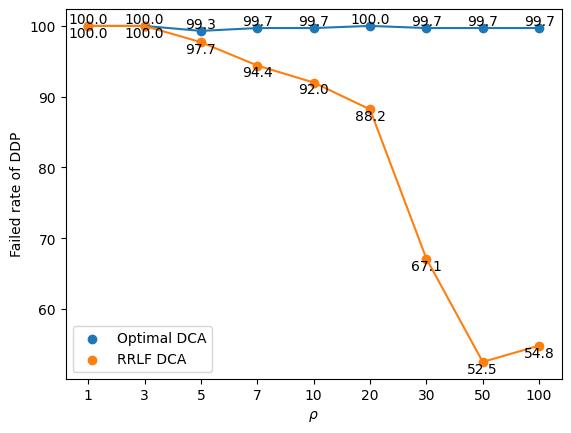

In [205]:
# types_name = {"optimal":"Optimal", "local_fair": "SLF", "global_fair": "GF", "reward_related_local_fair":"RRLF", "random":"Random", "still":'Still'}
test_types = ["optimal","reward_related_local_fair"]
# mean_value = {'JAL' : 0, 'SNE': 0, 'MNE': 0, 'NNE': 0, "random": 0, "optimal": 0,"local_fair": 0, "reward_related_local_fair": 0, "global_fair": 0}

failed_rate = {'optimal':[100, 100, 99.3, 99.7, 99.7, 100, 99.7, 99.7, 99.7],
                  'reward_related_local_fair':[100, 100, 97.7, 94.4, 92.0, 88.2, 67.1, 52.5, 54.8]}

keys = ['1', '3', '5', '7', '10', '20', '30', '50', '100']
# name = 'local_fair'
# for name in test_types:
  # DCA_op_mean = np.mean(np.array(op_action_trace[name][r]), axis=0)
  # # mean_value[name] = DCA_op_mean[-1]
plt.scatter(keys, failed_rate["optimal"], label=types_name["optimal"]+' DCA')

for key, value in zip(keys, failed_rate["optimal"]):
  plt.text(key, value, f'{value:.1f}', ha='center', va='bottom')

plt.plot(keys, failed_rate["optimal"], linestyle='-', marker='', markersize=2)


plt.scatter(keys, failed_rate["reward_related_local_fair"], label=types_name["reward_related_local_fair"]+' DCA')

for key, value in zip(keys, failed_rate["reward_related_local_fair"]):
  plt.text(key, value, f'{value:.1f}', ha='center', va='top')

plt.plot(keys, failed_rate["reward_related_local_fair"], linestyle='-', marker='', markersize=2)

# keys = ['1', '3', '5', '7', '10', '20', '30', '50', '100']
# # values = list(mean_value.values())

# # Create a bar plot
# plt.figure(figsize=(10, 6))  # Optional: Set the figure size
# # bars = plt.bar(keys, values, color='royalblue')
# plt.scatter(keys, values, color='royalblue')

# # Add labels for each bar
# # for bar, value in zip(bars, values):
# #     plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.4f}', ha='center', va='bottom')
# for key, value in zip(keys, values):
#     plt.text(key, value, f'{value:.4f}', ha='center', va='bottom')

# plt.plot(keys, values, linestyle='-', color='gray', marker='', markersize=2)

# plt.plot(range(len(JA_op_mean)), JA_op_mean, label="JAL")
# mean_value['JAL'] = JA_op_mean[-1]

# for name in IL_test_games:
#   IL_op_mean = np.mean(np.array(IL_op_trace[name]), axis=0)
#   mean_value[name] = IL_op_mean[-1]
#   plt.plot(range(len(IL_op_mean)), IL_op_mean, label='IL with '+name)

  # plt.plot(range(len(IL_op_mean)), IL_op_mean, label="Independent Learner")


plt.xlabel(r'$\rho$')
plt.ylabel('Failed rate of DDP')

plt.legend()

plt.savefig('DDP_failed.png', bbox_inches='tight')
# plt.show()

# Global Fairness Experiments

mean accumulated reward trend

accumulated reward difference



In [ ]:
op_action_trace
local_fairness
r_local_fairness
global_fairness
agent1_reward
agent2_reward
designer_policy

agent1_single_reward
agent2_single_reward

agent1_policy
agent2_policy
designer_choice

first_action_pairs
agent1_policy_choice
agent2_policy_choice


test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]
# test_types = ["random"]


In [165]:
success_idx ={"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[]}
test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]
for name in test_types:
  success_idx[name] = [i for i,subtrace in enumerate(op_action_trace[name]) if subtrace[-1]>=0.99]

In [166]:
global_fairness_success = {"optimal":[], "local_fair": [], "global_fair": [], "reward_related_local_fair": [], "random":[]}
test_types = ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]

for name in test_types:
  global_fairness_success[name] = [global_fairness[name][idx] for idx in success_idx[name]]

In [ ]:
global_fairness_mean = np.mean(np.array(global_fairness_success['optimal']), axis=0)
print(global_fairness_mean[0])

Mean local fairness

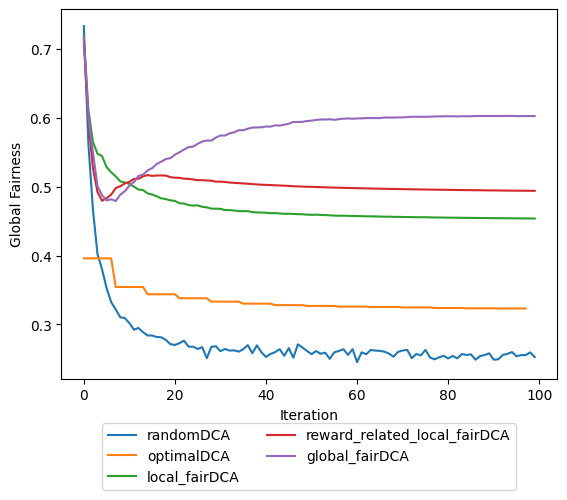

In [156]:
for name in test_types:
  global_fairness_mean = np.mean(np.array(global_fairness_success[name]), axis=0)
  if name == 'optimal':
    # global_fairness_mean = np.insert(global_fairness_mean, 0, 0.46)
    global_fairness_mean = [element for element in global_fairness_mean for _ in range(7)][:100]

  plt.plot(range(len(global_fairness_mean)), global_fairness_mean, label=name+"DCA")

plt.xlabel('Iteration')
plt.ylabel('Global Fairness')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.savefig('global_fairness_all_unbalanced.png', bbox_inches='tight')
plt.show()

## Reward difference

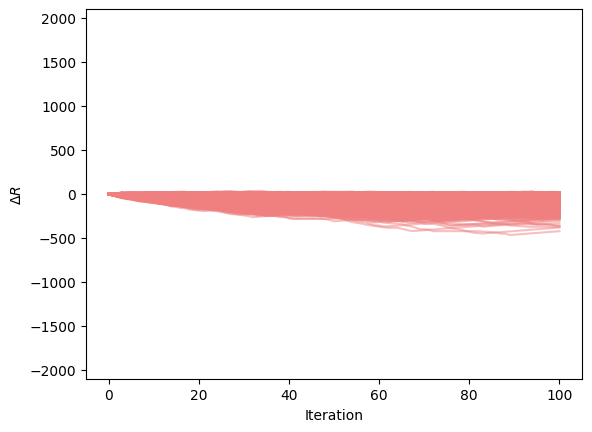

In [169]:
type_color = {"optimal": "royalblue", "local_fair": "orange", "global_fair": "lightcoral", "reward_related_local_fair": "green", "random": "darkviolet"}
# ["random", "optimal","local_fair", "reward_related_local_fair", "global_fair"]
# tt = ["optimal","local_fair", "reward_related_local_fair", 'random', 'global_fair']
tt = ["global_fair"]

for name in tt:
    reward_difference_mean = [np.array(agent1_reward[name][idx]) - np.array(agent2_reward[name][idx]) for idx in success_idx[name]]
    for trace in reward_difference_mean:
        plt.plot(range(len(trace)), trace, alpha = 0.5,  color=type_color[name])

# legend_handles = [plt.Line2D([0], [0], color=type_color[name], label=name) for name in test_types]
plt.ylim(-2100, 2100)

plt.xlabel('Iteration')
plt.ylabel(r'$\Delta R$')

# plt.legend(handles=legend_handles)
plt.savefig('global_reward_difference_GF_space2.png', bbox_inches='tight')


# plt.show()